In [1]:
# 1 📂 SNAPSHOT IMPORT - Campaign Statistics & Stock Data
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

# 📁 Snapshot Directory
snap_dir = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\snapshots")
print(f"📁 SNAP dir: {snap_dir}")

# 🧊 Import Campaign Statistics Snapshot
campaign_stats_path = snap_dir / "campaign_statistics.pkl"
campaign_stats = pd.read_pickle(campaign_stats_path)
print(f"🧊 Snapshot rebuilt: campaign_statistics.pkl  ({campaign_stats.shape[0]}×{campaign_stats.shape[1]})")

# 🧊 Import Detailed Stock List Snapshot  
stock_path = snap_dir / "detailed_stock_list.pkl"
stock_data = pd.read_pickle(stock_path)
print(f"🧊 Snapshot rebuilt: detailed_stock_list.pkl  ({stock_data.shape[0]}×{stock_data.shape[1]})")

print(f"\n✅ Snapshots loaded successfully")
print(f"📊 Analysis ready: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")

📁 SNAP dir: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\snapshots
🧊 Snapshot rebuilt: campaign_statistics.pkl  (175×23)
🧊 Snapshot rebuilt: detailed_stock_list.pkl  (4698×43)

✅ Snapshots loaded successfully
📊 Analysis ready: October 13, 2025 at 11:55:41


In [2]:
# 2 🎨 COLOR-CODED TOP 25 WINNERS BY WINE PRICE
from IPython.display import display

def format_swiss_number(number):
    """Format numbers in Swiss style with apostrophes (82'723.98)"""
    if pd.isna(number) or number == 0:
        return "0.00"
    
    # Round to 2 decimal places
    number = round(float(number), 2)
    
    # Split into integer and decimal parts
    integer_part = int(abs(number))
    decimal_part = f"{abs(number) - integer_part:.2f}"[2:]  # Get decimal part (2 digits)
    
    # Format integer part with apostrophes
    formatted_int = f"{integer_part:,}".replace(",", "'")
    result = f"{formatted_int}.{decimal_part}"
    
    return f"-{result}" if number < 0 else result

print("🎨 COLOR-CODED TOP 25 WINNERS BY WINE PRICE")
print("="*55)
print(f"📊 Analysis Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")
print("🏆 Winner Calculation: 60% Conversion Rate + 40% Total Sales Amount")
print("❌ Excluded: Type=Horeca/Trade, Sub-Type=Lead")
print("📊 Normalization: Norm_Conversion = conversion_rate/max_conversion | Norm_Sales = total_sales/max_sales")
print("💰 Swiss Formatting: Total Sales with apostrophes (82'723.98)\n")

# ---- Filter Campaign Statistics ----
campaigns = campaign_stats.copy()
print(f"📊 Total campaigns loaded: {len(campaigns)}")

# Apply filters using correct column names
campaigns_filtered = campaigns[
    (~campaigns['type'].isin(['Horeca', 'Trade'])) &
    (campaigns['sub-type'] != 'Lead')
].copy()

print(f"📊 After filtering (excluding Horeca/Trade & Lead): {len(campaigns_filtered)}")

# ---- Extract key columns for winner calculation ----
# Column references based on the actual data structure
conversion_rate = pd.to_numeric(campaigns_filtered['conversion rate %'], errors='coerce').fillna(0)
total_sales = pd.to_numeric(campaigns_filtered['total sales amount (lcy)'], errors='coerce').fillna(0)

# Other display columns
wine_name = campaigns_filtered['main wine name'].fillna('Unknown')
campaign_no = campaigns_filtered['campaign no.'].fillna('')
vintage_code = campaigns_filtered['vintage code'].fillna('')
scheduled_datetime = campaigns_filtered['scheduled datetime1'].fillna('')  # Using scheduled datetime1
multiple_wines = campaigns_filtered['multiple wines'].fillna('')
email_sent = pd.to_numeric(campaigns_filtered['email sent'], errors='coerce').fillna(0)
main_bottle_price = pd.to_numeric(campaigns_filtered['main bottle price (lcy)'], errors='coerce').fillna(0)
delayed_sending = campaigns_filtered['delayed sending'].fillna(False)
unique_customers_bought = pd.to_numeric(campaigns_filtered['total unique customers bought'], errors='coerce').fillna(0)

# ---- Calculate Winner Score (60% conversion + 40% sales) ----
# Normalize conversion rate and sales for scoring
max_conversion = max(conversion_rate.max(), 1e-12)  # Avoid division by zero
max_sales = max(total_sales.max(), 1e-12)

print(f"📊 Normalization factors: Max Conversion = {max_conversion:.2f}% | Max Sales = CHF {format_swiss_number(max_sales)}")

# Calculate normalized scores
norm_conversion = conversion_rate / max_conversion  # Each campaign's conversion / best conversion
norm_sales = total_sales / max_sales  # Each campaign's sales / best sales

# Final weighted score: 60% conversion + 40% sales
weighted_score = 0.6 * norm_conversion + 0.4 * norm_sales

# ---- Build Winners DataFrame ----
winners_df = pd.DataFrame({
    'Campaign_No': campaign_no,
    'Wine': wine_name,  # Renamed from Main_Wine_Name to Wine
    'Vintage': vintage_code,  # Renamed from Vintage_Code to Vintage
    'Starting_Date': scheduled_datetime,
    'Multiple': multiple_wines,
    'Email_Sent': email_sent,
    'Conversion_Rate_%': conversion_rate,
    'Total_Sales_Amount_LCY': total_sales,
    'Unique_Bought': unique_customers_bought,
    'Norm_Conversion': norm_conversion,
    'Norm_Sales': norm_sales,
    'Weighted_Score': weighted_score,
    'Main_Bottle_Price_LCY': main_bottle_price,
    'Delayed_Sending': delayed_sending
})

# Sort by weighted score (descending) and get top 25
winners_df = winners_df.sort_values('Weighted_Score', ascending=False).reset_index(drop=True)
top_25_winners = winners_df.head(25).copy()

# ---- Price Category Color Coding ----
def get_price_emoji(price):
    """Return emoji based on price tier"""
    if pd.isna(price) or price <= 0: return "⚪"
    if price >= 1000: return "🟣"  # Extra Luxury
    if price >= 500:  return "🟨"  # Luxury
    if price >= 150:  return "🟦"  # Premium
    if price >= 80:   return "🩷"  # Mid-Range
    return "🟢"  # Budget

# Add color coding and rank (on the right)
top_25_winners['🎨'] = top_25_winners['Main_Bottle_Price_LCY'].apply(get_price_emoji)
top_25_winners['Rank'] = range(1, len(top_25_winners) + 1)

# ---- Display Results ----
print("🎨 COLOR LEGEND:")
print("🟣 Purple: Extra Luxury (1000+ CHF)")
print("🟨 Gold:   Luxury (500+ CHF)")
print("🟦 Blue:   Premium (150+ CHF)")
print("🩷 Pink:   Mid-Range (80+ CHF)")
print("🟢 Green:  Budget (<80 CHF)")
print("⚪ White:  Unknown/No price\n")

# Prepare display table with requested columns order
display_table = top_25_winners[['Campaign_No', '🎨', 'Wine', 'Vintage', 'Starting_Date',
                               'Multiple', 'Email_Sent', 'Unique_Bought', 'Conversion_Rate_%', 'Total_Sales_Amount_LCY',
                               'Norm_Conversion', 'Norm_Sales', 'Weighted_Score', 'Delayed_Sending', 'Rank']].copy()

# Format wine names for better display
display_table['Wine'] = display_table['Wine'].astype(str).apply(
    lambda x: x if len(x) <= 25 else x[:25] + "…"
)

# Format vintage to show just the year number (remove .0)
display_table['Vintage'] = pd.to_numeric(display_table['Vintage'], errors='coerce').fillna(0).astype(int).astype(str).replace('0', '')

# Format starting date for better display (remove time, show only date)
display_table['Starting_Date'] = pd.to_datetime(display_table['Starting_Date'], errors='coerce').dt.strftime('%Y-%m-%d').fillna('')

# Add "-D" suffix to Campaign_No if Delayed_Sending is True
display_table['Campaign_No'] = display_table.apply(
    lambda row: f"{row['Campaign_No']}-D" if row['Delayed_Sending'] == True else str(row['Campaign_No']), 
    axis=1
)

# Format Total_Sales_Amount_LCY with Swiss formatting (2 decimal places)
display_table['Total_Sales_Amount_LCY'] = display_table['Total_Sales_Amount_LCY'].apply(format_swiss_number)

# Round numeric columns for better display
display_table['Norm_Conversion'] = display_table['Norm_Conversion'].round(4)
display_table['Norm_Sales'] = display_table['Norm_Sales'].round(4)
display_table['Weighted_Score'] = display_table['Weighted_Score'].round(4)

# Remove Delayed_Sending column from display (used only for formatting)
display_table = display_table.drop('Delayed_Sending', axis=1)

print("🏆 TOP 25 WINE CAMPAIGN WINNERS:")
display(display_table)

# ---- Summary Statistics ----
print("\n📊 WINNER ANALYSIS SUMMARY:")
print(f"• #1 Winner: {top_25_winners.iloc[0]['Wine']} | Weighted Score: {top_25_winners.iloc[0]['Weighted_Score']:.4f}")
print(f"• Price Range: CHF {top_25_winners['Main_Bottle_Price_LCY'].min():.0f} - CHF {top_25_winners['Main_Bottle_Price_LCY'].max():.0f}")
print(f"• Avg Conversion Rate: {top_25_winners['Conversion_Rate_%'].mean():.2f}%")
print(f"• Total Sales (Top 25): CHF {format_swiss_number(top_25_winners['Total_Sales_Amount_LCY'].sum())}")
print(f"• Total Emails Sent: {top_25_winners['Email_Sent'].sum():,.0f}")
print(f"• Total Unique Customers: {top_25_winners['Unique_Bought'].sum():,.0f}")
print(f"• Avg Normalized Conversion: {top_25_winners['Norm_Conversion'].mean():.4f}")
print(f"• Avg Normalized Sales: {top_25_winners['Norm_Sales'].mean():.4f}")
print(f"• Delayed Campaigns: {(top_25_winners['Delayed_Sending'] == True).sum()}/{len(top_25_winners)}")

# Price category distribution
print(f"\n🎨 PRICE CATEGORY DISTRIBUTION:")
price_categories = top_25_winners['🎨'].value_counts()
price_meanings = {
    "🟣": "Extra Luxury (1000+ CHF)",
    "🟨": "Luxury (500+ CHF)", 
    "🟦": "Premium (150+ CHF)",
    "🩷": "Mid-Range (80+ CHF)",
    "🟢": "Budget (<80 CHF)",
    "⚪": "Unknown/No price"
}

for emoji, count in price_categories.items():
    meaning = price_meanings.get(emoji, "Unknown")
    pct = 100 * count / len(top_25_winners)
    print(f"   {emoji} {meaning}: {count} campaigns ({pct:.1f}%)")

🎨 COLOR-CODED TOP 25 WINNERS BY WINE PRICE
📊 Analysis Date: October 13, 2025 at 11:56:21
🏆 Winner Calculation: 60% Conversion Rate + 40% Total Sales Amount
❌ Excluded: Type=Horeca/Trade, Sub-Type=Lead
📊 Normalization: Norm_Conversion = conversion_rate/max_conversion | Norm_Sales = total_sales/max_sales
💰 Swiss Formatting: Total Sales with apostrophes (82'723.98)

📊 Total campaigns loaded: 175
📊 After filtering (excluding Horeca/Trade & Lead): 153
📊 Normalization factors: Max Conversion = 7.14% | Max Sales = CHF 440'318.29
🎨 COLOR LEGEND:
🟣 Purple: Extra Luxury (1000+ CHF)
🟨 Gold:   Luxury (500+ CHF)
🟦 Blue:   Premium (150+ CHF)
🩷 Pink:   Mid-Range (80+ CHF)
🟢 Green:  Budget (<80 CHF)
⚪ White:  Unknown/No price

🏆 TOP 25 WINE CAMPAIGN WINNERS:


,Campaign_No,🎨,Wine,Vintage,Starting_Date,Multiple,Email_Sent,Unique_Bought,Conversion_Rate_%,Total_Sales_Amount_LCY,Norm_Conversion,Norm_Sales,Weighted_Score,Rank
0,CM-25-02231,🩷,Cos d'Estournel,2021,2025-08-29,1,3541,209,5.90,292'386.04,0.8263,0.6640,0.7614,1
1,CM-25-02451,🟦,Figeac,2018,2025-09-16,1,2759,148,5.36,274'386.06,0.7507,0.6232,0.6997,2
2,CM-25-02461,🟢,Le Petit Clos Apalta,2021,2025-09-18,2,28,2,7.14,1'332.00,1.0000,0.0030,0.6012,3
3,CM-25-02259,🟨,Masseto,2022,2025-09-02,2,228,11,4.82,200'839.06,0.6751,0.4561,0.5875,4
4,CM-25-02630,🟨,IX Proprietary Red Estate,2022,2025-10-02,1,405,23,5.68,91'999.73,0.7955,0.2089,0.5609,5
5,CM-25-02485,🟦,Champagne Extra Brut Gran…,2022,2025-09-18,1,2085,102,4.89,152'537.50,0.6849,0.3464,0.5495,6
6,CM-25-02255,🟢,Galatrona,2023,2025-09-02,1,3309,150,4.53,120'766.00,0.6345,0.2743,0.4904,7
7,CM-25-02394,🟢,Retout,2015,2025-09-11,1,106,6,5.66,2'298.24,0.7927,0.0052,0.4777,8
8,CM-25-02583,🟣,Cabernet Sauvignon,2021,2025-09-26,2,152,7,4.61,98'090.99,0.6457,0.2228,0.4765,9
9,CM-25-02602,🟦,Pavie,2019,2025-09-29,1,37210,218,0.59,440'318.29,0.0826,1.0000,0.4496,10



📊 WINNER ANALYSIS SUMMARY:
• #1 Winner: Cos d'Estournel | Weighted Score: 0.7614
• Price Range: CHF 11 - CHF 2500
• Avg Conversion Rate: 3.98%
• Total Sales (Top 25): CHF 2'692'928.09
• Total Emails Sent: 66,307
• Total Unique Customers: 1,410
• Avg Normalized Conversion: 0.5579
• Avg Normalized Sales: 0.2446
• Delayed Campaigns: 3/25

🎨 PRICE CATEGORY DISTRIBUTION:
   🟢 Budget (<80 CHF): 9 campaigns (36.0%)
   🟨 Luxury (500+ CHF): 6 campaigns (24.0%)
   🟦 Premium (150+ CHF): 5 campaigns (20.0%)
   🩷 Mid-Range (80+ CHF): 3 campaigns (12.0%)
   🟣 Extra Luxury (1000+ CHF): 2 campaigns (8.0%)


In [3]:
# 3 📅 MULTI-PERIOD WINNERS ANALYSIS WITH STOCK AVAILABILITY
from IPython.display import display
from datetime import datetime, timedelta

print("📅 MULTI-PERIOD WINNERS ANALYSIS WITH STOCK AVAILABILITY")
print("="*65)
print(f"📊 Analysis Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")
print("🎯 Period Analysis: Last 7, 14, 21, and 30 days")
print("📦 Stock Status: Based on Detailed Stock List (Column B)")
print("🏆 Winner Logic: 60% Conversion + 40% Sales (filtered by period)\n")

# ---- Stock Processing ----
print("📦 Processing Stock Data...")
stock_clean = stock_data.copy()

# Extract item ID from 'id' column and stock quantity from 'stock' column
stock_mapping = pd.DataFrame({
    'item_id': pd.to_numeric(stock_clean['id'], errors='coerce').fillna(0).astype(int),  # 'id' column as integer
    'stock_quantity': pd.to_numeric(stock_clean['stock'], errors='coerce').fillna(0)  # 'stock' column (quantity)
}).drop_duplicates(subset=['item_id'])

print(f"✅ Stock data processed: {len(stock_mapping)} unique items")
print(f"📊 Stock range: {stock_mapping['stock_quantity'].min():.0f} - {stock_mapping['stock_quantity'].max():.0f} bottles")

# ---- Stock Status Functions ----
def get_stock_emoji(quantity):
    """Return emoji based on stock quantity"""
    if pd.isna(quantity):
        return "⚪"  # Unknown
    elif quantity >= 11:
        return "🟢"  # Good for resending
    elif quantity >= 1:
        return "🟡"  # Proceed with caution
    else:
        return "🔴"  # Avoid resending

def get_stock_status(quantity):
    """Return stock status description"""
    if pd.isna(quantity):
        return "Unknown status"
    elif quantity >= 11:
        return f"Good ({int(quantity)} bottles)"
    elif quantity >= 1:
        return f"Caution ({int(quantity)} bottles)"
    else:
        return "Avoid (0 bottles)"

# ---- Price Category Functions (reuse from cell 2) ----
def get_price_emoji(price):
    """Return emoji based on price tier"""
    if pd.isna(price) or price <= 0: return "⚪"
    if price >= 1000: return "🟣"  # Extra Luxury
    if price >= 500:  return "🟨"  # Luxury
    if price >= 150:  return "🟦"  # Premium
    if price >= 80:   return "🩷"  # Mid-Range
    return "🟢"  # Budget

# ---- Period Analysis ----
current_date = datetime.now()
periods = [
    (7, "Last 7 Days", "🗓️"),
    (14, "Last 14 Days", "📅"), 
    (21, "Last 21 Days", "📆"),
    (30, "Last 30 Days", "🗓️")
]

print("📦 STOCK STATUS LEGEND:")
print("🟢 Green: 11+ bottles (good for resending campaigns)")
print("🟡 Yellow: 1-10 bottles (proceed with caution)")
print("🔴 Red: 0 bottles (avoid resending)")
print("⚪ White: Unknown status (item not found in stock list)\n")

print("🎨 PRICE TIER LEGEND:")
print("🟣 Purple: Extra Luxury (1000+ CHF) | 🟨 Gold: Luxury (500+ CHF)")
print("🟦 Blue: Premium (150+ CHF) | 🩷 Pink: Mid-Range (80+ CHF) | 🟢 Green: Budget (<80 CHF)\n")

# Use the winners data from cell 2 
winners_with_dates = top_25_winners.copy()

# Convert Starting_Date to datetime for filtering
winners_with_dates['Starting_Date_dt'] = pd.to_datetime(winners_with_dates['Starting_Date'], errors='coerce')

# Add stock information by matching main item numbers
# First, we need to get main item numbers from the original data
campaigns_with_items = campaigns_filtered.copy()
item_mapping = pd.DataFrame({
    'Campaign_No': campaigns_with_items['campaign no.'],
    'Main_Item_No': pd.to_numeric(campaigns_with_items['main item no.'], errors='coerce').fillna(0).astype(int)
})

# Merge with winners to get item numbers
winners_with_items = winners_with_dates.merge(
    item_mapping, 
    left_on='Campaign_No', 
    right_on='Campaign_No', 
    how='left'
)

# Match with stock data
winners_with_stock = winners_with_items.merge(
    stock_mapping,
    left_on='Main_Item_No',
    right_on='item_id',
    how='left'
)

# For each period, create analysis
for days, period_name, emoji in periods:
    print(f"\n{emoji} {period_name.upper()} ANALYSIS")
    print("-" * 50)
    
    # Filter by date range
    cutoff_date = current_date - timedelta(days=days)
    period_data = winners_with_stock[
        winners_with_stock['Starting_Date_dt'] >= cutoff_date
    ].copy()
    
    if period_data.empty:
        print(f"⚠️ No campaigns found in {period_name.lower()}")
        continue
    
    # Sort by weighted score and take top 10 for each period
    period_top = period_data.sort_values('Weighted_Score', ascending=False).head(10).copy()
    period_top['Period_Rank'] = range(1, len(period_top) + 1)
    
    # Add stock status
    period_top['📦'] = period_top['stock_quantity'].apply(get_stock_emoji)
    period_top['Stock_Status'] = period_top['stock_quantity'].apply(get_stock_status)
    
    # Prepare display table
    display_cols = [
        'Period_Rank', '🎨', '📦', 'Campaign_No', 'Wine', 'Vintage', 'Starting_Date',
        'Total_Sales_Amount_LCY', 'Conversion_Rate_%', 'Weighted_Score', 'Stock_Status', 'Main_Item_No'
    ]
    
    period_display = period_top[[col for col in display_cols if col in period_top.columns]].copy()
    
    # Format columns
    if 'Total_Sales_Amount_LCY' in period_display.columns:
        period_display['Total_Sales_Amount_LCY'] = period_display['Total_Sales_Amount_LCY'].apply(format_swiss_number)
    
    if 'Weighted_Score' in period_display.columns:
        period_display['Weighted_Score'] = period_display['Weighted_Score'].round(4)
    
    if 'Conversion_Rate_%' in period_display.columns:
        period_display['Conversion_Rate_%'] = period_display['Conversion_Rate_%'].round(2)
    
    # Format Starting_Date to show only date (no time)
    if 'Starting_Date' in period_display.columns:
        period_display['Starting_Date'] = pd.to_datetime(period_display['Starting_Date'], errors='coerce').dt.strftime('%Y-%m-%d').fillna('')
    
    # Format Vintage to show only year (remove .0)
    if 'Vintage' in period_display.columns:
        period_display['Vintage'] = pd.to_numeric(period_display['Vintage'], errors='coerce').fillna(0).astype(int).astype(str).replace('0', '')
    
    # Add -D suffix to Campaign_No if Delayed_Sending is True
    if 'Campaign_No' in period_display.columns and 'Delayed_Sending' in period_top.columns:
        period_display['Campaign_No'] = period_top.apply(
            lambda row: f"{row['Campaign_No']}-D" if row['Delayed_Sending'] == True else str(row['Campaign_No']), 
            axis=1
        )
    
    print(f"🏆 TOP 10 WINNERS - {period_name.upper()}:")
    display(period_display)
    
    # Period summary
    total_campaigns = len(period_data)
    good_stock = (period_top['📦'] == '🟢').sum()
    caution_stock = (period_top['📦'] == '🟡').sum()
    avoid_stock = (period_top['📦'] == '🔴').sum()
    unknown_stock = (period_top['📦'] == '⚪').sum()
    
    print(f"\n📊 {period_name.upper()} SUMMARY:")
    print(f"• Total campaigns in period: {total_campaigns}")
    print(f"• Top 10 campaigns analyzed")
    print(f"• Average weighted score: {period_top['Weighted_Score'].mean():.4f}")
    print(f"• Total sales (Top 10): CHF {format_swiss_number(period_top['Total_Sales_Amount_LCY'].sum())}")
    
    print(f"\n📦 STOCK DISTRIBUTION (Top 10):")
    if good_stock > 0:
        print(f"   🟢 Good for resending: {good_stock} campaigns ({100*good_stock/len(period_top):.1f}%)")
    if caution_stock > 0:
        print(f"   🟡 Proceed with caution: {caution_stock} campaigns ({100*caution_stock/len(period_top):.1f}%)")
    if avoid_stock > 0:
        print(f"   🔴 Avoid resending: {avoid_stock} campaigns ({100*avoid_stock/len(period_top):.1f}%)")
    if unknown_stock > 0:
        print(f"   ⚪ Unknown status: {unknown_stock} campaigns ({100*unknown_stock/len(period_top):.1f}%)")

print("\n🎯 MULTI-PERIOD ANALYSIS COMPLETE")
print("="*40)
print("📊 Use the stock status indicators to make resending decisions")
print("🟢 Green campaigns are ideal for immediate resending")
print("🟡 Yellow campaigns should be monitored closely") 
print("🔴 Red campaigns should be avoided until restocked")

📅 MULTI-PERIOD WINNERS ANALYSIS WITH STOCK AVAILABILITY
📊 Analysis Date: October 13, 2025 at 11:56:26
🎯 Period Analysis: Last 7, 14, 21, and 30 days
📦 Stock Status: Based on Detailed Stock List (Column B)
🏆 Winner Logic: 60% Conversion + 40% Sales (filtered by period)

📦 Processing Stock Data...
✅ Stock data processed: 4698 unique items
📊 Stock range: 1 - 14118 bottles
📦 STOCK STATUS LEGEND:
🟢 Green: 11+ bottles (good for resending campaigns)
🟡 Yellow: 1-10 bottles (proceed with caution)
🔴 Red: 0 bottles (avoid resending)
⚪ White: Unknown status (item not found in stock list)

🎨 PRICE TIER LEGEND:
🟣 Purple: Extra Luxury (1000+ CHF) | 🟨 Gold: Luxury (500+ CHF)
🟦 Blue: Premium (150+ CHF) | 🩷 Pink: Mid-Range (80+ CHF) | 🟢 Green: Budget (<80 CHF)


🗓️ LAST 7 DAYS ANALYSIS
--------------------------------------------------
🏆 TOP 10 WINNERS - LAST 7 DAYS:


,Period_Rank,🎨,📦,Campaign_No,Wine,Vintage,Starting_Date,Total_Sales_Amount_LCY,Conversion_Rate_%,Weighted_Score,Stock_Status,Main_Item_No
20,1,🩷,🟢,CM-25-02689-D,Nuits Saint Georges la Perrière,2021,2025-10-07,4'401.54,3.7,0.3149,Good (18 bottles),64885



📊 LAST 7 DAYS SUMMARY:
• Total campaigns in period: 1
• Top 10 campaigns analyzed
• Average weighted score: 0.3149
• Total sales (Top 10): CHF 4'401.54

📦 STOCK DISTRIBUTION (Top 10):
   🟢 Good for resending: 1 campaigns (100.0%)

📅 LAST 14 DAYS ANALYSIS
--------------------------------------------------
🏆 TOP 10 WINNERS - LAST 14 DAYS:


,Period_Rank,🎨,📦,Campaign_No,Wine,Vintage,Starting_Date,Total_Sales_Amount_LCY,Conversion_Rate_%,Weighted_Score,Stock_Status,Main_Item_No
4,1,🟨,🟢,CM-25-02630,IX Proprietary Red Estate,2022,2025-10-02,91'999.73,5.68,0.5609,Good (198 bottles),63171
12,2,🟦,⚪,CM-25-02625-D,El Tamboril Blanco,2016,2025-10-01,33'432.85,4.71,0.4262,Unknown status,65647
20,3,🩷,🟢,CM-25-02689-D,Nuits Saint Georges la Perrière,2021,2025-10-07,4'401.54,3.70,0.3149,Good (18 bottles),64885
21,4,🟨,🟡,CM-25-02637-D,Hommage à Jacques Perrin,2013,2025-10-03,1'587.81,3.57,0.3014,Caution (1 bottles),32234



📊 LAST 14 DAYS SUMMARY:
• Total campaigns in period: 4
• Top 10 campaigns analyzed
• Average weighted score: 0.4009
• Total sales (Top 10): CHF 131'421.93

📦 STOCK DISTRIBUTION (Top 10):
   🟢 Good for resending: 2 campaigns (50.0%)
   🟡 Proceed with caution: 1 campaigns (25.0%)
   ⚪ Unknown status: 1 campaigns (25.0%)

📆 LAST 21 DAYS ANALYSIS
--------------------------------------------------
🏆 TOP 10 WINNERS - LAST 21 DAYS:


,Period_Rank,🎨,📦,Campaign_No,Wine,Vintage,Starting_Date,Total_Sales_Amount_LCY,Conversion_Rate_%,Weighted_Score,Stock_Status,Main_Item_No
4,1,🟨,🟢,CM-25-02630,IX Proprietary Red Estate,2022,2025-10-02,91'999.73,5.68,0.5609,Good (198 bottles),63171
8,2,🟣,🟡,CM-25-02583,Cabernet Sauvignon,2021,2025-09-26,98'090.99,4.61,0.4765,Caution (3 bottles),62292
9,3,🟦,🟢,CM-25-02602,Pavie,2019,2025-09-29,440'318.29,0.59,0.4496,Good (438 bottles),51417
12,4,🟦,⚪,CM-25-02625-D,El Tamboril Blanco,2016,2025-10-01,33'432.85,4.71,0.4262,Unknown status,65647
14,5,🟢,⚪,CM-25-02592,Clos Floridène Blanc,2021,2025-09-26,23'636.75,4.21,0.3753,Unknown status,65529
18,6,🟢,🟢,CM-25-02577,Testamatta,2020,2025-09-25,5'067.57,3.85,0.3281,Good (702 bottles),56380
19,7,🟦,🟢,CM-25-02586,Champagne Dom Pérignon Special Edition Takashi...,2015,2025-09-26,55'037.05,3.25,0.3231,Good (54 bottles),65703
20,8,🩷,🟢,CM-25-02689-D,Nuits Saint Georges la Perrière,2021,2025-10-07,4'401.54,3.70,0.3149,Good (18 bottles),64885
21,9,🟨,🟡,CM-25-02637-D,Hommage à Jacques Perrin,2013,2025-10-03,1'587.81,3.57,0.3014,Caution (1 bottles),32234
24,10,🟣,🟢,CM-25-02598,Barolo Monfortino Riserva,2010,2025-09-28,82'215.29,2.09,0.2503,Good (42 bottles),43770



📊 LAST 21 DAYS SUMMARY:
• Total campaigns in period: 10
• Top 10 campaigns analyzed
• Average weighted score: 0.3806
• Total sales (Top 10): CHF 835'787.87

📦 STOCK DISTRIBUTION (Top 10):
   🟢 Good for resending: 6 campaigns (60.0%)
   🟡 Proceed with caution: 2 campaigns (20.0%)
   ⚪ Unknown status: 2 campaigns (20.0%)

🗓️ LAST 30 DAYS ANALYSIS
--------------------------------------------------
🏆 TOP 10 WINNERS - LAST 30 DAYS:


,Period_Rank,🎨,📦,Campaign_No,Wine,Vintage,Starting_Date,Total_Sales_Amount_LCY,Conversion_Rate_%,Weighted_Score,Stock_Status,Main_Item_No
1,1,🟦,🟢,CM-25-02451,Figeac,2018,2025-09-16,274'386.06,5.36,0.6997,Good (1110 bottles),48976
2,2,🟢,🟢,CM-25-02461,Le Petit Clos Apalta,2021,2025-09-18,1'332.00,7.14,0.6012,Good (156 bottles),62156
4,3,🟨,🟢,CM-25-02630,IX Proprietary Red Estate,2022,2025-10-02,91'999.73,5.68,0.5609,Good (198 bottles),63171
5,4,🟦,🟢,CM-25-02485,Champagne Extra Brut Grand Cru Le Mesnil,2022,2025-09-18,152'537.50,4.89,0.5495,Good (234 bottles),65596
8,5,🟣,🟡,CM-25-02583,Cabernet Sauvignon,2021,2025-09-26,98'090.99,4.61,0.4765,Caution (3 bottles),62292
9,6,🟦,🟢,CM-25-02602,Pavie,2019,2025-09-29,440'318.29,0.59,0.4496,Good (438 bottles),51417
12,7,🟦,⚪,CM-25-02625-D,El Tamboril Blanco,2016,2025-10-01,33'432.85,4.71,0.4262,Unknown status,65647
14,8,🟢,⚪,CM-25-02592,Clos Floridène Blanc,2021,2025-09-26,23'636.75,4.21,0.3753,Unknown status,65529
17,9,🩷,🟢,CM-25-02427,Yjar,2021,2025-09-15,48'012.73,3.51,0.3386,Good (216 bottles),65509
18,10,🟢,🟢,CM-25-02577,Testamatta,2020,2025-09-25,5'067.57,3.85,0.3281,Good (702 bottles),56380



📊 LAST 30 DAYS SUMMARY:
• Total campaigns in period: 15
• Top 10 campaigns analyzed
• Average weighted score: 0.4805
• Total sales (Top 10): CHF 1'168'814.46

📦 STOCK DISTRIBUTION (Top 10):
   🟢 Good for resending: 7 campaigns (70.0%)
   🟡 Proceed with caution: 1 campaigns (10.0%)
   ⚪ Unknown status: 2 campaigns (20.0%)

🎯 MULTI-PERIOD ANALYSIS COMPLETE
📊 Use the stock status indicators to make resending decisions
🟢 Green campaigns are ideal for immediate resending
🟡 Yellow campaigns should be monitored closely
🔴 Red campaigns should be avoided until restocked


In [9]:
# 4 📊 HISTORICAL TOP-15 MATRIX FOR RACE CHARTS
import json
from pathlib import Path
from datetime import datetime

print("📊 HISTORICAL TOP-15 MATRIX FOR RACE CHARTS")
print("="*50)
print(f"📅 Snapshot Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")

# ---- Prepare Historical Data Directory ----
historical_dir = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\historical")
historical_dir.mkdir(exist_ok=True)
print(f"📁 Historical dir: {historical_dir}")

# ---- Create Current Snapshot Data ----
# Use current date for each execution to track daily changes
data_date = datetime.now()
current_snapshot = {
    'timestamp': datetime.now().isoformat(),
    'date': data_date.strftime('%Y-%m-%d'),
    'analysis_date': data_date.strftime('%B %d, %Y'),
    'total_campaigns': len(campaigns_filtered),
    'max_conversion': max_conversion,
    'max_sales': max_sales,
    'top_15_winners': []
}

# Extract top 15 winners with key metrics for race charts
top_15_historical = top_25_winners.head(15).copy()

for idx, row in top_15_historical.iterrows():
    # Get price tier emoji
    price = row['Main_Bottle_Price_LCY']
    if pd.isna(price) or price <= 0: price_tier = "⚪"
    elif price >= 1000: price_tier = "🟣"  # Extra Luxury
    elif price >= 500:  price_tier = "🟨"  # Luxury
    elif price >= 150:  price_tier = "🟦"  # Premium
    elif price >= 80:   price_tier = "🩷"  # Mid-Range
    else: price_tier = "🟢"  # Budget
    
    winner_data = {
        'rank': idx + 1,
        'campaign_no': str(row['Campaign_No']),
        'wine_name': str(row['Wine'])[:30],  # Truncate for chart readability
        'vintage': str(row['Vintage']) if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else '',
        'weighted_score': round(float(row['Weighted_Score']), 4),
        'conversion_rate': round(float(row['Conversion_Rate_%']), 2),
        'total_sales': round(float(row['Total_Sales_Amount_LCY']), 2),
        'unique_customers': int(row['Unique_Bought']),
        'email_sent': int(row['Email_Sent']),
        'price_tier': price_tier,
        'main_bottle_price': round(float(row['Main_Bottle_Price_LCY']), 2),
        'norm_conversion': round(float(row['Norm_Conversion']), 4),
        'norm_sales': round(float(row['Norm_Sales']), 4),
        'delayed_sending': bool(row['Delayed_Sending']),
        'display_name': f"{str(row['Wine'])[:20]} {str(row['Vintage']) if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else ''}".strip()
    }
    current_snapshot['top_15_winners'].append(winner_data)

# ---- Load or Create Historical Matrix ----
historical_file = historical_dir / "top_15_winners_matrix.json"

if historical_file.exists():
    with open(historical_file, 'r', encoding='utf-8') as f:
        historical_data = json.load(f)
    print(f"📚 Loaded existing historical data: {len(historical_data['snapshots'])} snapshots")
else:
    historical_data = {
        'created_date': datetime.now().isoformat(),
        'description': 'Historical Top-15 Wine Campaign Winners Matrix for Race Charts',
        'snapshots': []
    }
    print("🆕 Created new historical matrix")

# ---- Add Current Snapshot ----
historical_data['snapshots'].append(current_snapshot)
historical_data['last_updated'] = datetime.now().isoformat()

# ---- Save Updated Historical Matrix ----
with open(historical_file, 'w', encoding='utf-8') as f:
    json.dump(historical_data, f, indent=2, ensure_ascii=False)

print(f"✅ Historical matrix updated: {len(historical_data['snapshots'])} total snapshots")
print(f"💾 Saved to: {historical_file}")

# ---- Export Race Chart Ready Data ----
race_chart_file = historical_dir / "race_chart_data.json"

# Prepare race chart format (each snapshot becomes a time point)
race_chart_data = {
    'metadata': {
        'title': 'Top Wine Campaign Winners Over Time',
        'description': 'Historical ranking of wine campaigns by weighted score',
        'created': historical_data['created_date'],
        'last_updated': datetime.now().isoformat(),
        'total_snapshots': len(historical_data['snapshots'])
    },
    'time_series': []
}

for snapshot in historical_data['snapshots']:
    time_point = {
        'date': snapshot['date'],
        'timestamp': snapshot['timestamp'],
        'analysis_date': snapshot['analysis_date'],
        'winners': []
    }
    
    for winner in snapshot['top_15_winners']:
        race_entry = {
            'rank': winner['rank'],
            'name': winner['display_name'],
            'campaign_no': winner['campaign_no'],
            'value': winner['weighted_score'],
            'sales': winner['total_sales'],
            'conversion': winner['conversion_rate'],
            'customers': winner['unique_customers'],
            'price_tier': winner['price_tier'],
            'color': {
                '🟣': '#8B5CF6',  # Purple
                '🟨': '#F59E0B',  # Gold
                '🟦': '#3B82F6',  # Blue
                '🩷': '#EC4899',  # Pink
                '🟢': '#10B981',  # Green
                '⚪': '#9CA3AF'   # Gray
            }.get(winner['price_tier'], '#9CA3AF')
        }
        time_point['winners'].append(race_entry)
    
    race_chart_data['time_series'].append(time_point)

# Save race chart data
with open(race_chart_file, 'w', encoding='utf-8') as f:
    json.dump(race_chart_data, f, indent=2, ensure_ascii=False)

print(f"🏁 Race chart data exported: {race_chart_file}")

# ---- Display Current Snapshot Summary ----
print(f"📊 CURRENT SNAPSHOT SUMMARY:")
print(f"• Snapshot ID: {len(historical_data['snapshots'])}")
print(f"• Date: {current_snapshot['analysis_date']}")
print(f"• Total Campaigns Analyzed: {current_snapshot['total_campaigns']}")
print(f"• Max Conversion Rate: {current_snapshot['max_conversion']:.2f}%")
print(f"• Max Sales: CHF {format_swiss_number(current_snapshot['max_sales'])}")
print(f"• Top 15 Winners Captured: {len(current_snapshot['top_15_winners'])}")

# ---- Display Top 15 Winners Table ----
print(f"\n🏆 TOP 15 WINNERS - CURRENT SNAPSHOT")
print("="*50)

# Create display table for top 15 winners
top_15_display = top_15_historical.copy()

# Merge wine name and vintage in same column
top_15_display['Wine_Vintage'] = top_15_display.apply(
    lambda row: f"{str(row['Wine'])} {str(row['Vintage'])}" if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else str(row['Wine']), 
    axis=1
)

# Format wine vintage for better display (truncate if too long)
top_15_display['Wine_Vintage'] = top_15_display['Wine_Vintage'].astype(str).apply(
    lambda x: x if len(x) <= 35 else x[:35] + "…"
)

# Add "-D" suffix to Campaign_No if Delayed_Sending is True
top_15_display['Campaign_No_Display'] = top_15_display.apply(
    lambda row: f"{row['Campaign_No']}-D" if row['Delayed_Sending'] == True else str(row['Campaign_No']), 
    axis=1
)

# Prepare final display columns
display_cols = ['Rank', '🎨', 'Campaign_No_Display', 'Wine_Vintage', 'Conversion_Rate_%', 
               'Total_Sales_Amount_LCY', 'Unique_Bought', 'Weighted_Score']

final_display = top_15_display[display_cols].copy()

# Format columns for display
final_display['Total_Sales_Amount_LCY'] = final_display['Total_Sales_Amount_LCY'].apply(format_swiss_number)
final_display['Conversion_Rate_%'] = final_display['Conversion_Rate_%'].round(2)
final_display['Weighted_Score'] = final_display['Weighted_Score'].round(4)

# Rename columns for better presentation
final_display.columns = ['Rank', '🎨', 'Campaign_No', 'Wine & Vintage', 'Conv_%', 
                        'Total_Sales_CHF', 'Unique_Customers', 'Weighted_Score']

display(final_display)

print(f"\n🏆 TOP 5 WINNERS IN CURRENT SNAPSHOT:")
for i in range(min(5, len(current_snapshot['top_15_winners']))):
    winner = current_snapshot['top_15_winners'][i]
    print(f"   {winner['rank']}. {winner['price_tier']} {winner['display_name']} - Score: {winner['weighted_score']}")

print(f"\n📈 HISTORICAL TRACKING:")
print(f"• Total Historical Snapshots: {len(historical_data['snapshots'])}")
print(f"• First Snapshot: {historical_data['snapshots'][0]['analysis_date'] if historical_data['snapshots'] else 'N/A'}")
print(f"• Data Range: {(datetime.fromisoformat(historical_data['snapshots'][-1]['timestamp']) - datetime.fromisoformat(historical_data['snapshots'][0]['timestamp'])).days if len(historical_data['snapshots']) > 1 else 0} days")

print(f"\n🎯 RACE CHART READY:")
print(f"• Time Series Points: {len(race_chart_data['time_series'])}")
print(f"• Winners per Snapshot: 15")
print(f"• Color-coded by Price Tier: Yes")
print(f"• Export Format: JSON for visualization tools")

# ---- Create Race Chart Data Table ----
print(f"\n🏁 RACE CHART DATA TABLE")
print("="*50)

# Load historical data to build the race chart table
if historical_file.exists():
    with open(historical_file, 'r', encoding='utf-8') as f:
        race_historical_data = json.load(f)
    
    # Build race chart table with campaigns as rows and dates as columns
    all_campaigns = set()
    date_columns = []
    
    # Collect all unique campaigns and dates
    for snapshot in race_historical_data['snapshots']:
        date_columns.append(snapshot['analysis_date'])
        for winner in snapshot['top_15_winners']:
            campaign_key = f"{winner['campaign_no']} | {winner['display_name']}"
            all_campaigns.add(campaign_key)
    
    # Sort campaigns by their best weighted score (from most recent snapshot)
    if race_historical_data['snapshots']:
        latest_snapshot = race_historical_data['snapshots'][-1]
        campaign_scores = {f"{w['campaign_no']} | {w['display_name']}": w['weighted_score'] 
                          for w in latest_snapshot['top_15_winners']}
        sorted_campaigns = sorted(all_campaigns, 
                                key=lambda x: campaign_scores.get(x, 0), 
                                reverse=True)
    else:
        sorted_campaigns = sorted(all_campaigns)
    
    # Create the race chart DataFrame
    race_chart_table = pd.DataFrame(index=sorted_campaigns)
    
    # Add campaign info columns
    race_chart_table['🎨'] = ''
    race_chart_table['Campaign_No'] = ''
    race_chart_table['Wine_Name'] = ''
    
    # Add date columns with weighted scores
    for snapshot in race_historical_data['snapshots']:
        date_col = snapshot['analysis_date']
        
        # Create a dictionary for quick lookup
        score_lookup = {}
        for winner in snapshot['top_15_winners']:
            campaign_key = f"{winner['campaign_no']} | {winner['display_name']}"
            score_lookup[campaign_key] = winner['weighted_score']
            
            # Fill campaign info (will be overwritten with same values, that's OK)
            if campaign_key in race_chart_table.index:
                race_chart_table.loc[campaign_key, '🎨'] = winner['price_tier']
                race_chart_table.loc[campaign_key, 'Campaign_No'] = winner['campaign_no']
                race_chart_table.loc[campaign_key, 'Wine_Name'] = winner['display_name']
        
        # Add scores for this date
        race_chart_table[date_col] = race_chart_table.index.map(
            lambda x: f"{score_lookup[x]:.4f}" if x in score_lookup else "-"
        )
    
    # Display the race chart table
    print(f"📊 Historical Weighted Scores by Campaign (Top 15 Winners)")
    print(f"📅 Snapshots: {len(date_columns)} | Campaigns: {len(sorted_campaigns)}")
    print("💡 Values show Weighted_Score (0.6*Conversion + 0.4*Sales), '-' means not in top 15")
    print()
    
    display(race_chart_table)
    
    # Additional insights
    print(f"\n📈 RACE CHART INSIGHTS:")
    
    # Count how many times each campaign appears in top 15
    appearance_count = {}
    for campaign in sorted_campaigns:
        count = 0
        for col in date_columns:
            if race_chart_table.loc[campaign, col] != "-":
                count += 1
        appearance_count[campaign] = count
    
    # Most consistent performers
    consistent_performers = sorted(appearance_count.items(), key=lambda x: x[1], reverse=True)[:5]
    print("🏆 Most Consistent Top-15 Performers:")
    for i, (campaign, count) in enumerate(consistent_performers, 1):
        pct = 100 * count / len(date_columns)
        print(f"   {i}. {campaign} - {count}/{len(date_columns)} snapshots ({pct:.1f}%)")
    
    # Latest leaders
    if race_historical_data['snapshots']:
        latest = race_historical_data['snapshots'][-1]
        print(f"\n🥇 Current Top 5 Leaders ({latest['analysis_date']}):")
        for i, winner in enumerate(latest['top_15_winners'][:5], 1):
            print(f"   {i}. {winner['price_tier']} {winner['display_name']} - {winner['weighted_score']:.4f}")
    
    print(f"\n💾 Race Chart Export Files:")
    print(f"   • CSV Ready: Copy table above for spreadsheet import")
    print(f"   • JSON Format: {race_chart_file.name}")
    print(f"   • Matrix Format: {historical_file.name}")

else:
    print("⚠️ No historical data found. Run this cell again after first execution.")

print(f"\n✅ Historical matrix snapshot complete!")
print("📁 Files created/updated:")
print(f"   • {historical_file.name}")
print(f"   • {race_chart_file.name}")
print("🏁 Ready for race chart visualization!")

📊 HISTORICAL TOP-15 MATRIX FOR RACE CHARTS
📅 Snapshot Date: October 13, 2025 at 12:01:18
📁 Historical dir: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\historical
📚 Loaded existing historical data: 12 snapshots
✅ Historical matrix updated: 13 total snapshots
💾 Saved to: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\historical\top_15_winners_matrix.json
🏁 Race chart data exported: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\historical\race_chart_data.json
📊 CURRENT SNAPSHOT SUMMARY:
• Snapshot ID: 13
• Date: October 13, 2025
• Total Campaigns Analyzed: 153
• Max Conversion Rate: 7.14%
• Max Sales: CHF 440'318.29
• Top 15 Winners Captured: 15

🏆 TOP 15 WINNERS - CURRENT SNAPSHOT


,Rank,🎨,Campaign_No,Wine & Vintage,Conv_%,Total_Sales_CHF,Unique_Customers,Weighted_Score
0,1,🩷,CM-25-02231,Cos d'Estournel 2021,5.90,292'386.04,209,0.7614
1,2,🟦,CM-25-02451,Figeac 2018,5.36,274'386.06,148,0.6997
2,3,🟢,CM-25-02461,Le Petit Clos Apalta 2021,7.14,1'332.00,2,0.6012
3,4,🟨,CM-25-02259,Masseto 2022,4.82,200'839.06,11,0.5875
4,5,🟨,CM-25-02630,IX Proprietary Red Estate 2022,5.68,91'999.73,23,0.5609
5,6,🟦,CM-25-02485,Champagne Extra Brut Grand Cru Le M…,4.89,152'537.50,102,0.5495
6,7,🟢,CM-25-02255,Galatrona 2023,4.53,120'766.00,150,0.4904
7,8,🟢,CM-25-02394,Retout 2015,5.66,2'298.24,6,0.4777
8,9,🟣,CM-25-02583,Cabernet Sauvignon 2021,4.61,98'090.99,7,0.4765
9,10,🟦,CM-25-02602,Pavie 2019,0.59,440'318.29,218,0.4496



🏆 TOP 5 WINNERS IN CURRENT SNAPSHOT:
   1. 🩷 Cos d'Estournel 2021 - Score: 0.7614
   2. 🟦 Figeac 2018 - Score: 0.6997
   3. 🟢 Le Petit Clos Apalta 2021 - Score: 0.6012
   4. 🟨 Masseto 2022 - Score: 0.5875
   5. 🟨 IX Proprietary Red E 2022 - Score: 0.5609

📈 HISTORICAL TRACKING:
• Total Historical Snapshots: 13
• First Snapshot: October 10, 2025
• Data Range: 2 days

🎯 RACE CHART READY:
• Time Series Points: 13
• Winners per Snapshot: 15
• Color-coded by Price Tier: Yes
• Export Format: JSON for visualization tools

🏁 RACE CHART DATA TABLE
📊 Historical Weighted Scores by Campaign (Top 15 Winners)
📅 Snapshots: 13 | Campaigns: 15
💡 Values show Weighted_Score (0.6*Conversion + 0.4*Sales), '-' means not in top 15



,🎨,Campaign_No,Wine_Name,"October 10, 2025","October 09, 2025","October 13, 2025"
CM-25-02231 | Cos d'Estournel 2021,🩷,CM-25-02231,Cos d'Estournel 2021,0.7623,0.7614,0.7614
CM-25-02451 | Figeac 2018,🟦,CM-25-02451,Figeac 2018,0.7006,0.6997,0.6997
CM-25-02461 | Le Petit Clos Apalta 2021,🟢,CM-25-02461,Le Petit Clos Apalta 2021,0.6012,0.6012,0.6012
CM-25-02259 | Masseto 2022,🟨,CM-25-02259,Masseto 2022,0.5881,0.5875,0.5875
CM-25-02630 | IX Proprietary Red E 2022,🟨,CM-25-02630,IX Proprietary Red E 2022,0.5368,0.5609,0.5609
CM-25-02485 | Champagne Extra Brut 2022,🟦,CM-25-02485,Champagne Extra Brut 2022,0.5504,0.5495,0.5495
CM-25-02255 | Galatrona 2023,🟢,CM-25-02255,Galatrona 2023,0.4908,0.4904,0.4904
CM-25-02394 | Retout 2015,🟢,CM-25-02394,Retout 2015,0.4777,0.4777,0.4777
CM-25-02583 | Cabernet Sauvignon 2021,🟣,CM-25-02583,Cabernet Sauvignon 2021,0.4768,0.4765,0.4765
CM-25-02602 | Pavie 2019,🟦,CM-25-02602,Pavie 2019,0.4588,0.4496,0.4496



📈 RACE CHART INSIGHTS:
🏆 Most Consistent Top-15 Performers:
   1. CM-25-02231 | Cos d'Estournel 2021 - 13/13 snapshots (100.0%)
   2. CM-25-02451 | Figeac 2018 - 13/13 snapshots (100.0%)
   3. CM-25-02461 | Le Petit Clos Apalta 2021 - 13/13 snapshots (100.0%)
   4. CM-25-02259 | Masseto 2022 - 13/13 snapshots (100.0%)
   5. CM-25-02630 | IX Proprietary Red E 2022 - 13/13 snapshots (100.0%)

🥇 Current Top 5 Leaders (October 13, 2025):
   1. 🩷 Cos d'Estournel 2021 - 0.7614
   2. 🟦 Figeac 2018 - 0.6997
   3. 🟢 Le Petit Clos Apalta 2021 - 0.6012
   4. 🟨 Masseto 2022 - 0.5875
   5. 🟨 IX Proprietary Red E 2022 - 0.5609

💾 Race Chart Export Files:
   • CSV Ready: Copy table above for spreadsheet import
   • JSON Format: race_chart_data.json
   • Matrix Format: top_15_winners_matrix.json

✅ Historical matrix snapshot complete!
📁 Files created/updated:
   • top_15_winners_matrix.json
   • race_chart_data.json
🏁 Ready for race chart visualization!


📊 RACE CHART VISUALIZATIONS - Bar Charts
📅 Visualization Date: October 13, 2025 at 11:56:40
✅ Required data verified: 25 winners available
📊 Creating Last 7 Days Race Chart...
📊 Creating Last 14 Days Race Chart...
📊 Creating Overall Winners Race Chart...


C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_44492\2457489128.py:182: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_44492\2457489128.py:182: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_44492\2457489128.py:182: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_44492\2457489128.py:182: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Marco.Africani\AppData\Local\anaconda3\envs\avu311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Marco.Africani\AppData\Local\anaconda3\env

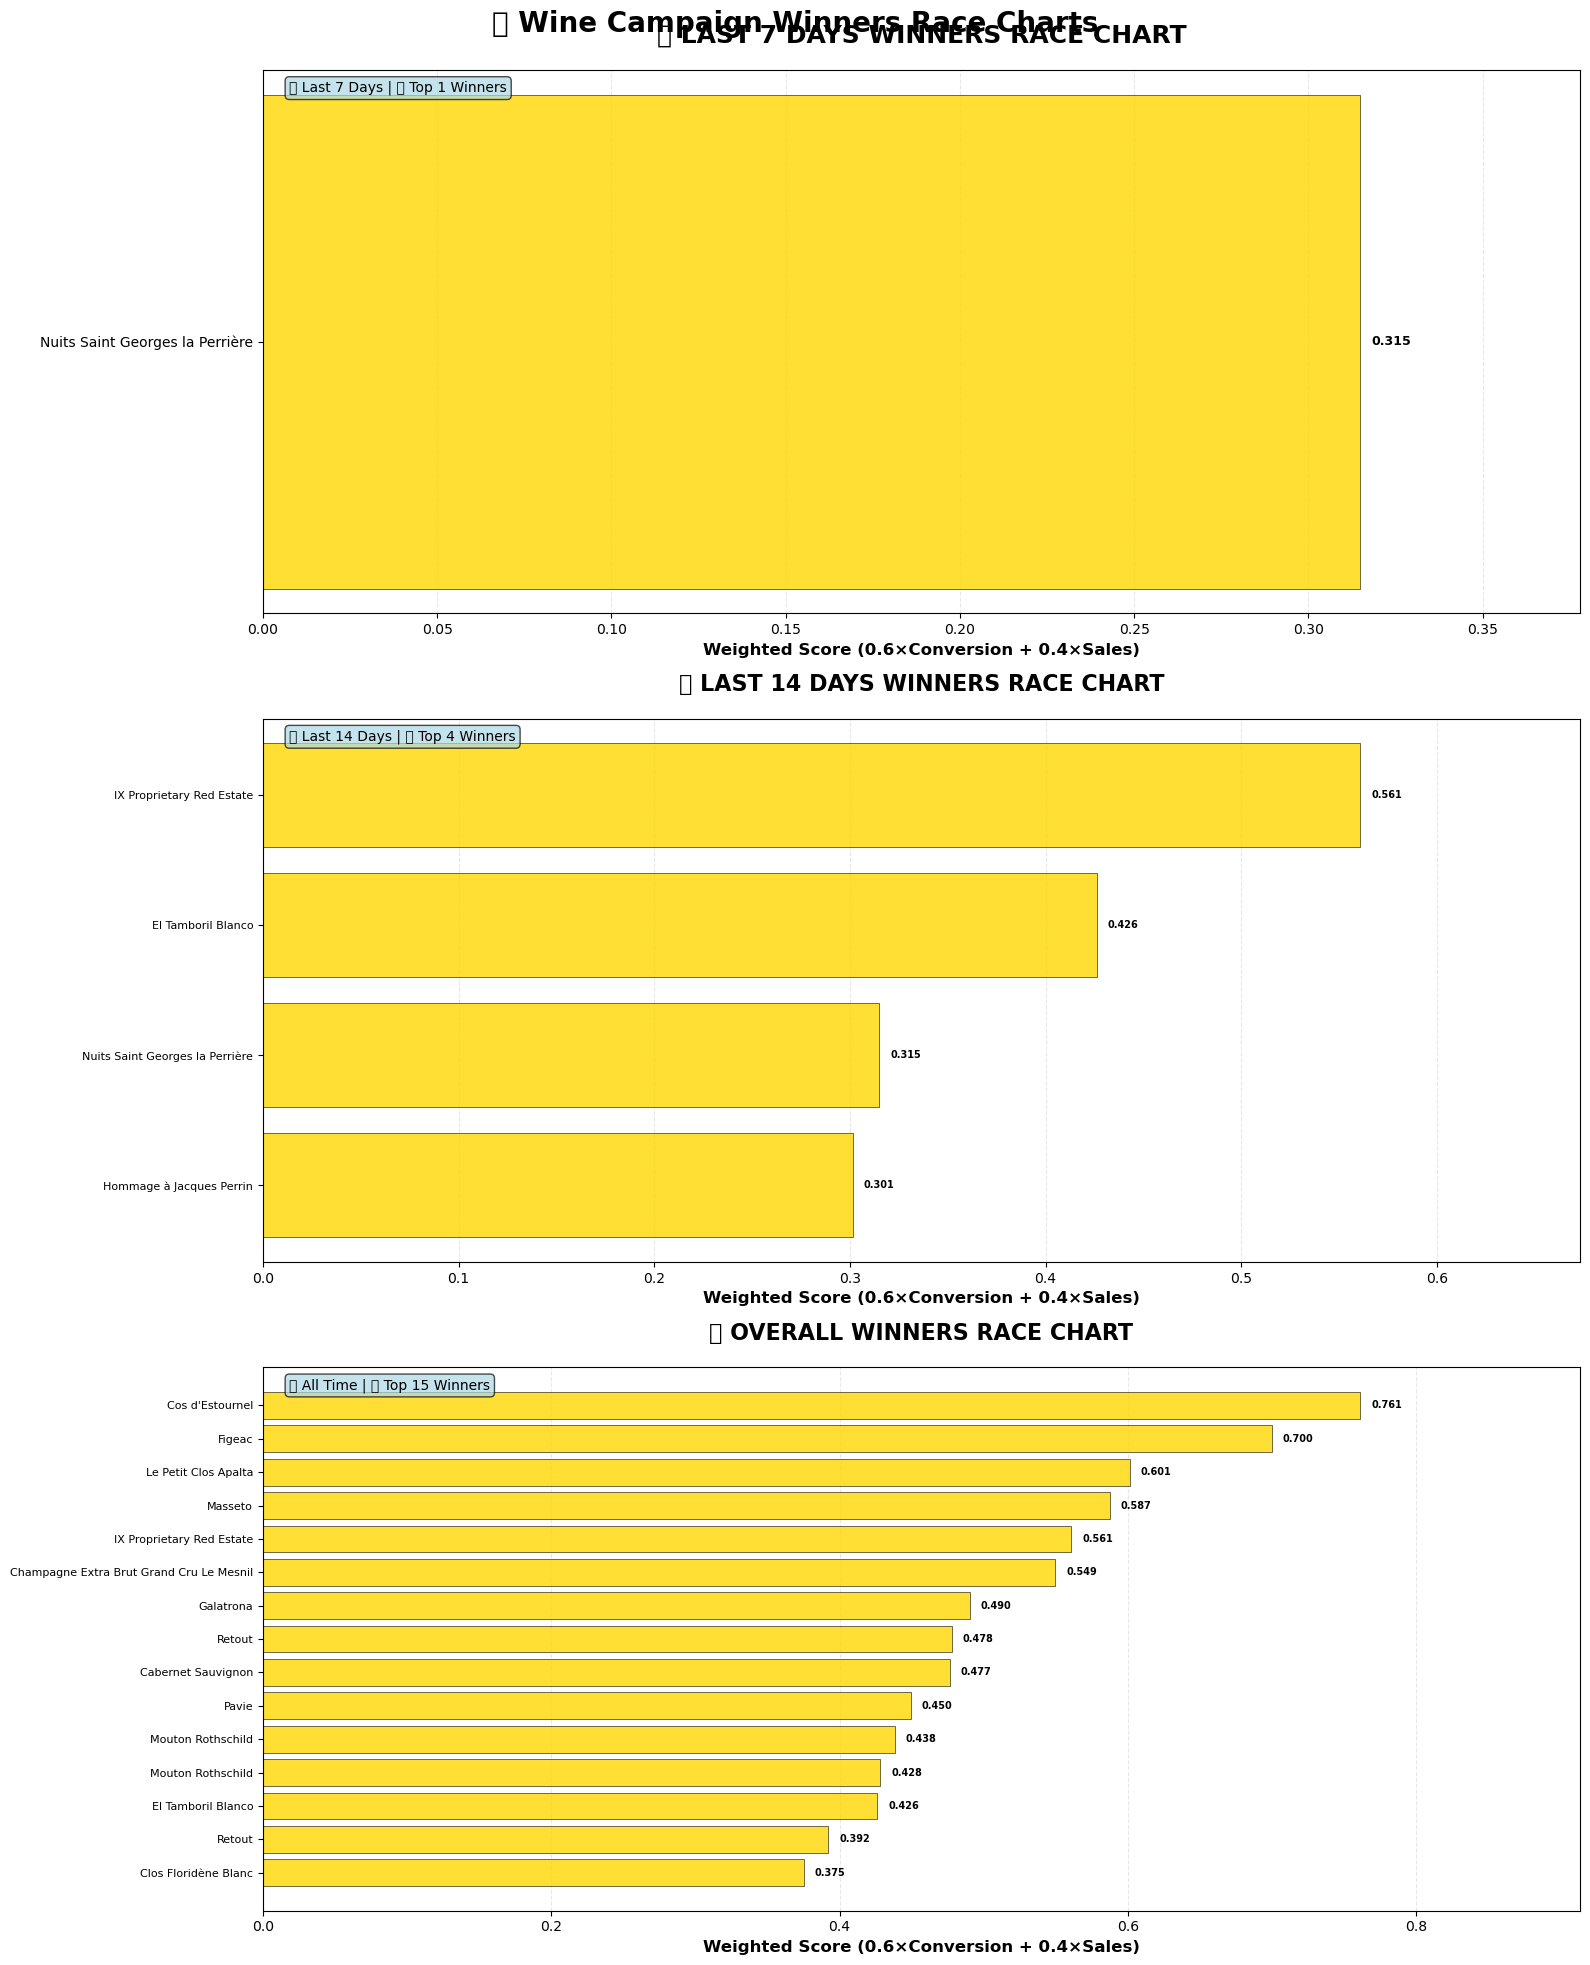


📈 RACE CHART SUMMARY:
🗓️ LAST 7 DAYS:
   • Winners: 1
   • Top Winner: Nuits Saint Georges la Perrière (Score: 0.3149)
   • Avg Score: 0.3149
   • Total Sales: CHF 4'401.54

📅 LAST 14 DAYS:
   • Winners: 4
   • Top Winner: IX Proprietary Red Estate (Score: 0.5609)
   • Avg Score: 0.4009
   • Total Sales: CHF 131'421.93

🏁 OVERALL:
   • Winners: 15
   • Top Winner: Cos d'Estournel (Score: 0.7614)
   • Avg Score: 0.5143
   • Total Sales: CHF 2'190'945.22

🎨 PRICE TIER DISTRIBUTION ACROSS PERIODS:

🗓️ Last 7 Days:
   🩷 Mid-Range (80+ CHF): 1 (100.0%)

📅 Last 14 Days:
   🟨 Luxury (500+ CHF): 2 (50.0%)
   🟦 Premium (150+ CHF): 1 (25.0%)
   🩷 Mid-Range (80+ CHF): 1 (25.0%)

🏁 Overall:
   🟢 Budget (<80 CHF): 5 (33.3%)
   🟦 Premium (150+ CHF): 4 (26.7%)
   🟨 Luxury (500+ CHF): 4 (26.7%)
   🩷 Mid-Range (80+ CHF): 1 (6.7%)
   🟣 Extra Luxury (1000+ CHF): 1 (6.7%)

✅ Race chart visualizations complete!
📊 Charts show weighted scores (0.6×Conversion + 0.4×Sales)
🟨 Golden color used for all bars for

In [5]:
# 5 📊 RACE CHART VISUALIZATIONS - Bar Charts
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
import numpy as np
from datetime import datetime, timedelta
import pandas as pd

# Enable matplotlib inline display
%matplotlib inline

print("📊 RACE CHART VISUALIZATIONS - Bar Charts")
print("="*50)
print(f"📅 Visualization Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")

try:
    # Verify required data is available
    if 'top_25_winners' not in globals():
        print("⚠️ Error: top_25_winners not found. Please run previous cells first.")
        raise Exception("Missing required data from previous cells")
    
    if 'format_swiss_number' not in globals():
        print("⚠️ Error: format_swiss_number function not found. Please run Cell 2 first.")
        raise Exception("Missing required function from previous cells")
    
    print(f"✅ Required data verified: {len(top_25_winners)} winners available")
    
    # Set up the figure with 3 subplots (3 rows, 1 column)
    fig, axes = plt.subplots(3, 1, figsize=(16, 20))
    fig.suptitle('🏁 Wine Campaign Winners Race Charts', fontsize=20, fontweight='bold', y=0.98)

    # Define color mapping for price tiers
    color_map = {
        '🟣': '#8B5CF6',  # Purple - Extra Luxury
        '🟨': '#F59E0B',  # Gold - Luxury
        '🟦': '#3B82F6',  # Blue - Premium
        '🩷': '#EC4899',  # Pink - Mid-Range
        '🟢': '#10B981',  # Green - Budget
        '⚪': '#9CA3AF'   # Gray - Unknown
    }

    # Helper function to get period data
    def get_period_winners(period_days=None):
        """Get top 15 winners for a specific period or overall"""
        try:
            if period_days is None:
                # Overall - use top_25_winners
                if not top_25_winners.empty:
                    return top_25_winners.head(15).copy()
                else:
                    print("⚠️ Warning: top_25_winners is empty")
                    return pd.DataFrame()
            else:
                # Period-specific filtering
                current_date = datetime.now()
                cutoff_date = current_date - timedelta(days=period_days)
                
                period_campaigns = top_25_winners.copy()
                
                # Ensure Starting_Date column exists and convert to datetime
                if 'Starting_Date' not in period_campaigns.columns:
                    print(f"⚠️ Warning: Starting_Date column not found for {period_days}-day period")
                    return pd.DataFrame()
                
                period_campaigns['Starting_Date_dt'] = pd.to_datetime(period_campaigns['Starting_Date'], errors='coerce')
                
                # Filter by date range
                period_filtered = period_campaigns[
                    period_campaigns['Starting_Date_dt'] >= cutoff_date
                ].copy()
                
                if period_filtered.empty:
                    print(f"⚠️ Info: No campaigns found in last {period_days} days")
                    return pd.DataFrame()
                
                return period_filtered.sort_values('Weighted_Score', ascending=False).head(15).copy()
        except Exception as e:
            print(f"⚠️ Error in get_period_winners for {period_days} days: {e}")
            return pd.DataFrame()

    # Helper function to create bar chart
    def create_race_bar_chart(ax, winners_data, title, period_label, chart_size="normal"):
        """Create a horizontal bar chart for race data"""
        try:
            if winners_data.empty:
                ax.text(0.5, 0.5, f'No data available for {period_label}', 
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax.transAxes, fontsize=14, 
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
                ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                return
            
            # Prepare data
            campaigns = []
            scores = []
            
            for idx, row in winners_data.iterrows():
                # Display only wine name (no campaign number, no vintage)
                wine_name = str(row['Wine'])
                campaigns.append(wine_name)
                scores.append(float(row['Weighted_Score']))
            
            # Reverse order for horizontal bar chart (highest at top)
            campaigns.reverse()
            scores.reverse()
            
            # Create horizontal bar chart with golden color for all bars
            y_pos = np.arange(len(campaigns))
            bars = ax.barh(y_pos, scores, color='#FFD700', alpha=0.8, edgecolor='black', linewidth=0.5)
            
            # Customize the chart
            ax.set_yticks(y_pos)
            ax.set_yticklabels(campaigns, fontsize=10 if chart_size == "large" else 8)
            ax.set_xlabel('Weighted Score (0.6×Conversion + 0.4×Sales)', fontsize=12, fontweight='bold')
            ax.set_title(title, fontsize=18 if chart_size == "large" else 16, fontweight='bold', pad=20)
            
            # Add value labels on bars
            for i, (bar, score) in enumerate(zip(bars, scores)):
                width = bar.get_width()
                ax.text(width + max(scores) * 0.01, bar.get_y() + bar.get_height()/2, 
                        f'{score:.3f}', ha='left', va='center', 
                        fontsize=9 if chart_size == "large" else 7, fontweight='bold')
            
            # Add grid for better readability
            ax.grid(axis='x', alpha=0.3, linestyle='--')
            ax.set_axisbelow(True)
            
            # Set x-axis limits with some padding
            max_score = max(scores) if scores else 1
            ax.set_xlim(0, max_score * 1.2)
            
            # Add period info
            info_text = f"📅 {period_label} | 🏆 Top {len(campaigns)} Winners"
            ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))
        
        except Exception as e:
            print(f"⚠️ Error in create_race_bar_chart for {period_label}: {e}")
            ax.text(0.5, 0.5, f'Error creating chart for {period_label}\n{str(e)}', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes, fontsize=12, color='red',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='pink', alpha=0.7))
            ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

    # ---- Chart 1: Last 7 Days (Biggest) ----
    print("📊 Creating Last 7 Days Race Chart...")
    last_7_days = get_period_winners(7)
    create_race_bar_chart(
        axes[0], 
        last_7_days, 
        "🗓️ LAST 7 DAYS WINNERS RACE CHART", 
        "Last 7 Days",
        "large"
    )

    # ---- Chart 2: Last 14 Days ----
    print("📊 Creating Last 14 Days Race Chart...")
    last_14_days = get_period_winners(14)
    create_race_bar_chart(
        axes[1], 
        last_14_days, 
        "📅 LAST 14 DAYS WINNERS RACE CHART", 
        "Last 14 Days",
        "normal"
    )

    # ---- Chart 3: Overall Winners ----
    print("📊 Creating Overall Winners Race Chart...")
    overall_winners = get_period_winners(None)
    create_race_bar_chart(
        axes[2], 
        overall_winners, 
        "🏁 OVERALL WINNERS RACE CHART", 
        "All Time",
        "normal"
    )

    # Adjust layout (no legend needed since all bars are golden)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    # Display the charts
    plt.show()

    # ---- Summary Statistics ----
    print("\n📈 RACE CHART SUMMARY:")
    print("="*40)

    print(f"🗓️ LAST 7 DAYS:")
    if not last_7_days.empty:
        print(f"   • Winners: {len(last_7_days)}")
        print(f"   • Top Winner: {last_7_days.iloc[0]['Wine']} (Score: {last_7_days.iloc[0]['Weighted_Score']:.4f})")
        print(f"   • Avg Score: {last_7_days['Weighted_Score'].mean():.4f}")
        print(f"   • Total Sales: CHF {format_swiss_number(last_7_days['Total_Sales_Amount_LCY'].sum())}")
    else:
        print("   • No campaigns in last 7 days")

    print(f"\n📅 LAST 14 DAYS:")
    if not last_14_days.empty:
        print(f"   • Winners: {len(last_14_days)}")
        print(f"   • Top Winner: {last_14_days.iloc[0]['Wine']} (Score: {last_14_days.iloc[0]['Weighted_Score']:.4f})")
        print(f"   • Avg Score: {last_14_days['Weighted_Score'].mean():.4f}")
        print(f"   • Total Sales: CHF {format_swiss_number(last_14_days['Total_Sales_Amount_LCY'].sum())}")
    else:
        print("   • No campaigns in last 14 days")

    print(f"\n🏁 OVERALL:")
    if not overall_winners.empty:
        print(f"   • Winners: {len(overall_winners)}")
        print(f"   • Top Winner: {overall_winners.iloc[0]['Wine']} (Score: {overall_winners.iloc[0]['Weighted_Score']:.4f})")
        print(f"   • Avg Score: {overall_winners['Weighted_Score'].mean():.4f}")
        print(f"   • Total Sales: CHF {format_swiss_number(overall_winners['Total_Sales_Amount_LCY'].sum())}")
    else:
        print("   • No overall winners data")

    # ---- Price Distribution Analysis ----
    print(f"\n🎨 PRICE TIER DISTRIBUTION ACROSS PERIODS:")
    print("="*50)

    def analyze_price_distribution(data, period_name):
        try:
            if data.empty:
                print(f"{period_name}: No data")
                return
            
            if '🎨' in data.columns:
                price_dist = data['🎨'].value_counts()
                print(f"\n{period_name}:")
                for emoji, count in price_dist.items():
                    meaning = price_meanings.get(emoji, "Unknown")
                    pct = 100 * count / len(data)
                    print(f"   {emoji} {meaning}: {count} ({pct:.1f}%)")
            else:
                print(f"{period_name}: Price tier data not available")
        except Exception as e:
            print(f"⚠️ Error analyzing {period_name}: {e}")

    analyze_price_distribution(last_7_days, "🗓️ Last 7 Days")
    analyze_price_distribution(last_14_days, "📅 Last 14 Days") 
    analyze_price_distribution(overall_winners, "🏁 Overall")

    print(f"\n✅ Race chart visualizations complete!")
    print("📊 Charts show weighted scores (0.6×Conversion + 0.4×Sales)")
    print("🟨 Golden color used for all bars for consistency")
    print("📈 Larger chart emphasizes recent 7-day performance")
    print("🍷 Only wine names displayed for cleaner visualization")

except Exception as e:
    print(f"⚠️ CRITICAL ERROR in Cell 5: {str(e)}")
    print("📋 Troubleshooting steps:")
    print("   1. Ensure all previous cells (1-4) have been run successfully")
    print("   2. Check that top_25_winners DataFrame exists")
    print("   3. Verify matplotlib is properly installed")
    print("   4. Try restarting the kernel if issues persist")
    import traceback

    print(f"\n🔍 Full error trace:")
    traceback.print_exc()

In [16]:
# 6 📊 HTML DASHBOARD - AVU TOP CAMPAIGNS RACE CHARTS

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import base64
from io import BytesIO
from pathlib import Path

print("📊 HTML DASHBOARD - AVU TOP CAMPAIGNS RACE CHARTS")
print("="*55)
print(f"📅 Dashboard Creation Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")

try:
    # Verify required data is available
    if 'top_25_winners' not in globals():
        print("⚠️ Error: top_25_winners not found. Please run previous cells first.")
        raise Exception("Missing required data from previous cells")
    
    if 'format_swiss_number' not in globals():
        print("⚠️ Error: format_swiss_number function not found. Please run Cell 2 first.")
        raise Exception("Missing required function from previous cells")
    
    print(f"✅ Required data verified: {len(top_25_winners)} winners available")
    
    # Helper function to get period data (reuse from cell 5)
    def get_period_winners(period_days=None):
        """Get top 15 winners for a specific period or overall"""
        try:
            if period_days is None:
                # Overall - use top_25_winners
                if not top_25_winners.empty:
                    return top_25_winners.head(15).copy()
                else:
                    return pd.DataFrame()
            else:
                # Period-specific filtering
                current_date = datetime.now()
                cutoff_date = current_date - timedelta(days=period_days)
                
                period_campaigns = top_25_winners.copy()
                
                if 'Starting_Date' not in period_campaigns.columns:
                    return pd.DataFrame()
                
                period_campaigns['Starting_Date_dt'] = pd.to_datetime(period_campaigns['Starting_Date'], errors='coerce')
                
                # Filter by date range
                period_filtered = period_campaigns[
                    period_campaigns['Starting_Date_dt'] >= cutoff_date
                ].copy()
                
                if period_filtered.empty:
                    return pd.DataFrame()
                
                return period_filtered.sort_values('Weighted_Score', ascending=False).head(15).copy()
        except Exception as e:
            print(f"⚠️ Error in get_period_winners for {period_days} days: {e}")
            return pd.DataFrame()

    # Function to create chart and return base64 string
    def create_chart_base64(winners_data, title, chart_size="normal", min_winners=5):
        """Create a horizontal bar chart and return as base64 string"""
        try:
            if winners_data.empty:
                # Create empty chart placeholder
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.text(0.5, 0.5, 'No data available', 
                        horizontalalignment='center', verticalalignment='center',
                        fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor='gold', alpha=0.7))
                ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.axis('off')
            else:
                # Prepare data - include wine name AND vintage
                campaigns = []
                scores = []
                
                # Ensure minimum number of winners
                display_data = winners_data.head(max(min_winners, len(winners_data)))
                
                for idx, row in display_data.iterrows():
                    wine_name = str(row['Wine'])
                    vintage = str(row['Vintage']) if pd.notna(row['Vintage']) and str(row['Vintage']) != '0' else ''
                    
                    # Combine wine name and vintage
                    if vintage:
                        full_name = f"{wine_name} {vintage}"
                    else:
                        full_name = wine_name
                    
                    # Truncate if too long for display
                    if len(full_name) > 35:
                        full_name = full_name[:32] + "..."
                    
                    campaigns.append(full_name)
                    scores.append(float(row['Weighted_Score']))
                
                # Reverse order for horizontal bar chart (highest at top)
                campaigns.reverse()
                scores.reverse()
                
                # Set figure size based on chart size
                if chart_size == "large":
                    fig, ax = plt.subplots(figsize=(14, max(8, len(campaigns) * 0.6)))
                    title_size = 18
                    label_size = 12
                    tick_size = 10
                elif chart_size == "medium":
                    fig, ax = plt.subplots(figsize=(12, max(6, len(campaigns) * 0.5)))
                    title_size = 16
                    label_size = 11
                    tick_size = 9
                else:
                    fig, ax = plt.subplots(figsize=(10, max(5, len(campaigns) * 0.4)))
                    title_size = 14
                    label_size = 10
                    tick_size = 8
                
                # Create horizontal bar chart with golden gradient effect
                y_pos = np.arange(len(campaigns))
                
                # Create gradient colors - REVERSED: darker on top, lighter on bottom
                colors = []
                for i in range(len(campaigns)):
                    # Gradient from bright gold (#FFD700) to dark gold (#B8860B)
                    # Top rows (higher index in reversed list) get darker colors
                    ratio = (len(campaigns) - 1 - i) / max(1, len(campaigns) - 1)
                    r = int(255 - (255 - 184) * ratio)  # Red: 255->184 (bright to dark)
                    g = int(215 - (215 - 134) * ratio)  # Green: 215->134 (bright to dark)  
                    b = int(0 + (11 - 0) * ratio)       # Blue: 0->11 (bright to dark)
                    colors.append(f"#{r:02x}{g:02x}{b:02x}")
                
                bars = ax.barh(y_pos, scores, color=colors, alpha=0.9, edgecolor='#8B4513', linewidth=1.5)
                
                # Customize the chart
                ax.set_yticks(y_pos)
                ax.set_yticklabels(campaigns, fontsize=tick_size)
                ax.set_xlabel('Weighted Score (0.6×Conversion + 0.4×Sales)', fontsize=label_size, fontweight='bold')
                ax.set_title(title, fontsize=title_size, fontweight='bold', pad=20)
                
                # Add value labels on bars
                for i, (bar, score) in enumerate(zip(bars, scores)):
                    width = bar.get_width()
                    ax.text(width + max(scores) * 0.01, bar.get_y() + bar.get_height()/2, 
                            f'{score:.3f}', ha='left', va='center', 
                            fontsize=tick_size-1, fontweight='bold')
                
                # Add grid for better readability
                ax.grid(axis='x', alpha=0.3, linestyle='--')
                ax.set_axisbelow(True)
                
                # Set x-axis limits with some padding
                max_score = max(scores) if scores else 1
                ax.set_xlim(0, max_score * 1.15)
            
            # Convert plot to base64 string
            buffer = BytesIO()
            plt.tight_layout()
            plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')
            buffer.seek(0)
            image_base64 = base64.b64encode(buffer.getvalue()).decode()
            plt.close(fig)
            
            return image_base64
        
        except Exception as e:
            print(f"⚠️ Error creating chart: {e}")
            # Return empty placeholder
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.text(0.5, 0.5, f'Error creating chart\n{str(e)}', 
                    horizontalalignment='center', verticalalignment='center',
                    fontsize=12, color='red', bbox=dict(boxstyle="round,pad=0.3", facecolor='pink', alpha=0.7))
            ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
            ax.axis('off')
            
            buffer = BytesIO()
            plt.tight_layout()
            plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')
            buffer.seek(0)
            image_base64 = base64.b64encode(buffer.getvalue()).decode()
            plt.close(fig)
            
            return image_base64

    # Get data for the 3 charts
    print("📊 Generating chart data...")
    last_7_days = get_period_winners(7)
    last_21_days = get_period_winners(21)
    overall_winners = get_period_winners(None)
    
    print(f"   • Last 7 Days: {len(last_7_days)} winners")
    print(f"   • Last 21 Days: {len(last_21_days)} winners")
    print(f"   • Overall: {len(overall_winners)} winners")
    
    # Create base64 images for each chart
    print("📊 Creating chart images...")
    
    # For 7-day chart, use overall winners if not enough data, ensure min 5 winners
    chart_7_data = last_7_days if len(last_7_days) >= 5 else overall_winners.head(5)
    chart_7_days = create_chart_base64(chart_7_data, "🗓️ LAST 7 DAYS WINNERS", "large", min_winners=5)
    
    chart_21_days = create_chart_base64(last_21_days, "📆 LAST 21 DAYS WINNERS", "medium", min_winners=5)
    chart_overall = create_chart_base64(overall_winners, "🏁 OVERALL WINNERS", "medium", min_winners=5)
    
    # Get current timestamp
    current_time = datetime.now().strftime('%B %d, %Y at %H:%M:%S')
    
    # Create HTML content
    html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>AVU Top Campaigns Dashboard</title>
    <style>
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            margin: 0;
            padding: 20px;
            background: linear-gradient(135deg, #2C3E50 0%, #34495E 50%, #1A252F 100%);
            min-height: 100vh;
        }}
        
        .dashboard-container {{
            max-width: 1400px;
            margin: 0 auto;
            background: white;
            border-radius: 15px;
            box-shadow: 0 20px 40px rgba(0,0,0,0.1);
            overflow: hidden;
        }}
        
        .header {{
            background: linear-gradient(135deg, #FFFFFF 0%, #F8F9FA 100%);
            padding: 30px;
            text-align: center;
            color: #333;
            position: relative;
            border-bottom: 3px solid #FFD700;
        }}
        
        .header h1 {{
            margin: 0;
            font-size: 2.5em;
            font-weight: bold;
            text-shadow: 2px 2px 4px rgba(0,0,0,0.1);
        }}
        
        .logo {{
            position: absolute;
            top: 15px;
            left: 30px;
            height: 70px;
            width: auto;
            border-radius: 8px;
            box-shadow: 0 4px 8px rgba(0,0,0,0.1);
            background: rgba(255,255,255,0.9);
            padding: 5px;
        }}
        
        .header .subtitle {{
            margin: 10px 0 0 0;
            font-size: 1.2em;
            opacity: 0.8;
        }}
        
        .header .timestamp {{
            margin: 15px 0 0 0;
            font-size: 1em;
            background: rgba(255,255,255,0.3);
            padding: 8px 16px;
            border-radius: 20px;
            display: inline-block;
        }}
        
        .rotate-button {{
            background: linear-gradient(135deg, #28a745 0%, #20c997 100%);
            color: white;
            border: none;
            padding: 12px 24px;
            font-size: 1.1em;
            font-weight: bold;
            border-radius: 25px;
            cursor: pointer;
            margin: 20px 0 10px 0;
            transition: all 0.3s ease;
            box-shadow: 0 4px 8px rgba(0,0,0,0.2);
        }}
        
        .rotate-button:hover {{
            background: linear-gradient(135deg, #218838 0%, #1fa85f 100%);
            transform: translateY(-2px);
            box-shadow: 0 6px 12px rgba(0,0,0,0.3);
        }}
        
        .rotate-button:active {{
            transform: translateY(0);
            box-shadow: 0 2px 4px rgba(0,0,0,0.2);
        }}
        
        .charts-container {{
            padding: 30px;
            background: #f8f9fa;
        }}
        
        .chart-grid {{
            display: grid;
            grid-template-columns: 1fr 1fr;
            grid-template-rows: auto auto;
            gap: 30px;
            height: auto;
        }}
        
        .chart-main {{
            grid-column: 1 / -1;
            background: white;
            border-radius: 10px;
            box-shadow: 0 8px 16px rgba(0,0,0,0.1);
            padding: 20px;
            border: 3px solid #FFD700;
        }}
        
        .chart-secondary {{
            background: white;
            border-radius: 10px;
            box-shadow: 0 8px 16px rgba(0,0,0,0.1);
            padding: 20px;
            border: 2px solid #ddd;
        }}
        
        .chart-image {{
            width: 100%;
            height: auto;
            border-radius: 8px;
        }}
        
        .chart-title {{
            font-size: 1.3em;
            font-weight: bold;
            margin-bottom: 15px;
            color: #333;
            text-align: center;
            padding: 10px;
            background: linear-gradient(135deg, #f8f9fa 0%, #e9ecef 100%);
            border-radius: 8px;
        }}
        
        .chart-title::before {{
            content: "";
            display: inline-block;
            width: 20px;
            height: 20px;
            margin-right: 8px;
            background: #FFD700;
            border-radius: 3px;
            vertical-align: middle;
        }}
        
        .chart-title[data-chart="7days"]::before {{
            background: linear-gradient(45deg, #FF6B35, #F7931E);
        }}
        
        .chart-title[data-chart="21days"]::before {{
            background: linear-gradient(45deg, #4ECDC4, #44A08D);
        }}
        
        .chart-title[data-chart="overall"]::before {{
            background: linear-gradient(45deg, #667eea, #764ba2);
        }}
        
        .footer {{
            background: #333;
            color: white;
            padding: 20px;
            text-align: center;
        }}
        
        .stats-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 20px;
            margin: 20px 0;
        }}
        
        .stat-card {{
            background: rgba(255,255,255,0.1);
            padding: 15px;
            border-radius: 8px;
            text-align: center;
        }}
        
        .stat-number {{
            font-size: 1.5em;
            font-weight: bold;
            color: #FFD700;
        }}
        
        .stat-label {{
            font-size: 0.9em;
            opacity: 0.8;
            margin-top: 5px;
        }}
        
        @media (max-width: 768px) {{
            .chart-grid {{
                grid-template-columns: 1fr;
            }}
            
            .chart-main {{
                grid-column: 1;
            }}
            
            .header h1 {{
                font-size: 2em;
            }}
            
            .logo {{
                position: static;
                display: block;
                margin: 0 auto 15px auto;
                height: 50px;
            }}
        }}
    </style>
</head>
<body>
    <div class="dashboard-container">
        <div class="header">
            <!-- AVU Company Logo -->
            <img src="assets/avu_logo_white.png" alt="AVU Logo" class="logo">
            <h1>🏆 AVU TOP CAMPAIGNS</h1>
            <div class="subtitle">Wine Campaign Winners Dashboard</div>
            <div class="timestamp">📅 Last Updated: {current_time}</div>
            <button class="rotate-button" onclick="rotateCharts()">🔄 Rotate Charts</button>
        </div>
        
        <div class="charts-container">
            <div class="chart-grid">
                <!-- Chart Position 1: Main (Top Center) -->
                <div class="chart-main" id="chart-position-1">
                    <div class="chart-title" id="title-position-1" data-chart="7days">LAST 7 DAYS WINNERS - FEATURED</div>
                    <img src="data:image/png;base64,{chart_7_days}" alt="Chart 1" class="chart-image" id="image-position-1">
                </div>
                
                <!-- Chart Position 2: Secondary (Bottom Left) -->
                <div class="chart-secondary" id="chart-position-2">
                    <div class="chart-title" id="title-position-2" data-chart="21days">LAST 21 DAYS WINNERS</div>
                    <img src="data:image/png;base64,{chart_21_days}" alt="Chart 2" class="chart-image" id="image-position-2">
                </div>
                
                <!-- Chart Position 3: Secondary (Bottom Right) -->
                <div class="chart-secondary" id="chart-position-3">
                    <div class="chart-title" id="title-position-3" data-chart="overall">OVERALL TOP WINNERS</div>
                    <img src="data:image/png;base64,{chart_overall}" alt="Chart 3" class="chart-image" id="image-position-3">
                </div>
            </div>
        </div>
        
        <div class="footer">
            <div class="stats-grid">
                <div class="stat-card">
                    <div class="stat-number">{len(last_7_days)}</div>
                    <div class="stat-label">7-Day Winners</div>
                </div>
                <div class="stat-card">
                    <div class="stat-number">{len(last_21_days)}</div>
                    <div class="stat-label">21-Day Winners</div>
                </div>
                <div class="stat-card">
                    <div class="stat-number">{len(overall_winners)}</div>
                    <div class="stat-label">Overall Winners</div>
                </div>
                <div class="stat-card">
                    <div class="stat-number">{len(top_25_winners)}</div>
                    <div class="stat-label">Total Campaigns</div>
                </div>
            </div>
            <p>🍷 Wine Campaign Analysis Dashboard | Weighted Score: 60% Conversion + 40% Sales</p>
            <p>🟨 Golden bars represent top-performing campaigns | Generated: {current_time}</p>
        </div>
    </div>
    
    <script>
        // Chart rotation functionality
        let currentRotation = 0;
        
        // Chart data arrays - [title, image_src, alt_text, chart_type]
        const chartData = [
            ["LAST 7 DAYS WINNERS - FEATURED", "data:image/png;base64,{chart_7_days}", "Last 7 Days Winners Chart", "7days"],
            ["LAST 21 DAYS WINNERS", "data:image/png;base64,{chart_21_days}", "Last 21 Days Winners Chart", "21days"],
            ["OVERALL TOP WINNERS", "data:image/png;base64,{chart_overall}", "Overall Winners Chart", "overall"]
        ];
        
        function rotateCharts() {{
            // Increment rotation counter (anticlockwise means we move indices forward)
            currentRotation = (currentRotation + 1) % 3;
            
            // Calculate new positions for each chart
            // Position 1 (main): gets chart from position 3
            // Position 2 (bottom-left): gets chart from position 1  
            // Position 3 (bottom-right): gets chart from position 2
            const newPositions = [
                (2 - currentRotation + 3) % 3,  // Position 1 gets previous position 3
                (0 - currentRotation + 3) % 3,  // Position 2 gets previous position 1
                (1 - currentRotation + 3) % 3   // Position 3 gets previous position 2
            ];
            
            // Update each position with the rotated chart
            for (let pos = 0; pos < 3; pos++) {{
                const chartIndex = newPositions[pos];
                const positionNum = pos + 1;
                
                // Update title and chart type
                const titleElement = document.getElementById(`title-position-${{positionNum}}`);
                titleElement.textContent = chartData[chartIndex][0];
                titleElement.setAttribute('data-chart', chartData[chartIndex][3]);
                
                // Update image
                const imgElement = document.getElementById(`image-position-${{positionNum}}`);
                imgElement.src = chartData[chartIndex][1];
                imgElement.alt = chartData[chartIndex][2];
            }}
            
            // Add visual feedback
            const button = document.querySelector('.rotate-button');
            button.textContent = '🔄 Rotating...';
            button.disabled = true;
            
            // Add rotation animation effect
            const chartGrid = document.querySelector('.chart-grid');
            chartGrid.style.transition = 'transform 0.5s ease-in-out';
            chartGrid.style.transform = 'rotate(-5deg)';
            
            setTimeout(() => {{
                chartGrid.style.transform = 'rotate(0deg)';
                button.textContent = '🔄 Rotate Charts';
                button.disabled = false;
            }}, 500);
            
            // Update button text temporarily to show rotation direction
            setTimeout(() => {{
                button.textContent = '🔄 Rotate Charts ↺';
                setTimeout(() => {{
                    button.textContent = '🔄 Rotate Charts';
                }}, 1000);
            }}, 100);
        }}
        
        // Add keyboard shortcut (R key)
        document.addEventListener('keydown', function(event) {{
            if (event.key === 'r' || event.key === 'R') {{
                if (!event.ctrlKey && !event.altKey && !event.metaKey) {{
                    rotateCharts();
                }}
            }}
        }});
        
        // Add some visual improvements
        document.addEventListener('DOMContentLoaded', function() {{
            // Add hover effects to charts
            const charts = document.querySelectorAll('.chart-main, .chart-secondary');
            charts.forEach(chart => {{
                chart.addEventListener('mouseenter', function() {{
                    this.style.transform = 'scale(1.02)';
                    this.style.transition = 'transform 0.3s ease';
                }});
                
                chart.addEventListener('mouseleave', function() {{
                    this.style.transform = 'scale(1)';
                }});
            }});
        }});
    </script>
</body>
</html>
"""
    
    # Save HTML file
    output_dir = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard")
    output_dir.mkdir(exist_ok=True)
    
    html_file = output_dir / "avu_top_campaigns_dashboard.html"
    
    with open(html_file, 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    print(f"✅ HTML Dashboard created successfully!")
    print(f"📁 Saved to: {html_file}")
    print(f"🌐 File size: {html_file.stat().st_size / 1024:.1f} KB")
    
    # Display summary
    print(f"\n📊 DASHBOARD SUMMARY:")
    print(f"• Main Chart (Top Center): Last 7 Days - {len(last_7_days)} winners")
    print(f"• Bottom Left: Last 21 Days - {len(last_21_days)} winners")  
    print(f"• Bottom Right: Overall Winners - {len(overall_winners)} winners")
    print(f"• Last Updated: {current_time}")
    
    # Additional stats
    if not last_7_days.empty:
        print(f"\n🗓️ LAST 7 DAYS HIGHLIGHTS:")
        print(f"   • Top Winner: {last_7_days.iloc[0]['Wine']}")
        print(f"   • Best Score: {last_7_days.iloc[0]['Weighted_Score']:.4f}")
        print(f"   • Total Sales: CHF {format_swiss_number(last_7_days['Total_Sales_Amount_LCY'].sum())}")
    
    if not overall_winners.empty:
        print(f"\n🏁 OVERALL HIGHLIGHTS:")
        print(f"   • Top Winner: {overall_winners.iloc[0]['Wine']}")
        print(f"   • Best Score: {overall_winners.iloc[0]['Weighted_Score']:.4f}")
        print(f"   • Total Sales: CHF {format_swiss_number(overall_winners['Total_Sales_Amount_LCY'].sum())}")
    
    print(f"\n🎯 NEXT STEPS:")
    print(f"   • Open the HTML file in your browser to view the dashboard")
    print(f"   • Share the dashboard URL for team access")
    print(f"   • Re-run this cell to update with latest data")
    print(f"   • Dashboard auto-updates timestamp on each generation")

except Exception as e:
    print(f"⚠️ CRITICAL ERROR in HTML Dashboard Creation: {str(e)}")
    print("📋 Troubleshooting steps:")
    print("   1. Ensure all previous cells (1-5) have been run successfully")
    print("   2. Check that matplotlib and pandas are properly installed")
    print("   3. Verify file write permissions to output directory")
    print("   4. Try restarting the kernel if issues persist")
    import traceback
    print(f"\n🔍 Full error trace:")
    traceback.print_exc()

📊 HTML DASHBOARD - AVU TOP CAMPAIGNS RACE CHARTS
📅 Dashboard Creation Date: October 13, 2025 at 12:28:42
✅ Required data verified: 25 winners available
📊 Generating chart data...
   • Last 7 Days: 1 winners
   • Last 21 Days: 10 winners
   • Overall: 15 winners
📊 Creating chart images...


C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_44492\1567989921.py:161: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_44492\1567989921.py:162: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')
C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_44492\1567989921.py:161: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_44492\1567989921.py:162: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.savefig(buffer, format='png', dpi=100, bbox_inches='tight')
C:\Users\Marco.Africani\AppData\Local\Temp\ipykernel_44492\1567989921.py:161: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  plt.tight_lay

✅ HTML Dashboard created successfully!
📁 Saved to: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard\avu_top_campaigns_dashboard.html
🌐 File size: 518.7 KB

📊 DASHBOARD SUMMARY:
• Main Chart (Top Center): Last 7 Days - 1 winners
• Bottom Left: Last 21 Days - 10 winners
• Bottom Right: Overall Winners - 15 winners
• Last Updated: October 13, 2025 at 12:28:43

🗓️ LAST 7 DAYS HIGHLIGHTS:
   • Top Winner: Nuits Saint Georges la Perrière
   • Best Score: 0.3149
   • Total Sales: CHF 4'401.54

🏁 OVERALL HIGHLIGHTS:
   • Top Winner: Cos d'Estournel
   • Best Score: 0.7614
   • Total Sales: CHF 2'190'945.22

🎯 NEXT STEPS:
   • Open the HTML file in your browser to view the dashboard
   • Share the dashboard URL for team access
   • Re-run this cell to update with latest data
   • Dashboard auto-updates timestamp on each generation


In [12]:
# 7 🌐 NETWORK SHARING - Broadcast Dashboard on Local Network

import http.server
import socketserver
import threading
import socket
import webbrowser
from pathlib import Path
import time

print("🌐 NETWORK SHARING - AVU DASHBOARD")
print("="*50)
print(f"📅 Network Setup Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")

# Configuration
PORT = 8080
dashboard_dir = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard")

def get_local_ip():
    """Get the local IP address"""
    try:
        # Connect to a remote server to get the local IP
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        s.connect(("8.8.8.8", 80))
        local_ip = s.getsockname()[0]
        s.close()
        return local_ip
    except Exception:
        return "127.0.0.1"

def start_server(port, directory):
    """Start HTTP server in a separate thread"""
    class CustomHTTPRequestHandler(http.server.SimpleHTTPRequestHandler):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, directory=str(directory), **kwargs)
        
        def log_message(self, format, *args):
            """Override to reduce server output"""
            return
    
    try:
        with socketserver.TCPServer(("", port), CustomHTTPRequestHandler) as httpd:
            print(f"🚀 Server started successfully on port {port}")
            httpd.serve_forever()
    except OSError as e:
        if "Address already in use" in str(e):
            print(f"⚠️ Port {port} is already in use. Try a different port or stop existing server.")
        else:
            print(f"⚠️ Server error: {e}")
    except Exception as e:
        print(f"⚠️ Unexpected server error: {e}")

# Check if dashboard file exists
dashboard_file = dashboard_dir / "avu_top_campaigns_dashboard.html"
if not dashboard_file.exists():
    print("⚠️ Dashboard file not found. Please run Cell 6 first to create the dashboard.")
    print(f"📁 Expected location: {dashboard_file}")
else:
    print(f"✅ Dashboard file found: {dashboard_file.name}")
    print(f"📁 Server directory: {dashboard_dir}")
    
    # Get network information
    local_ip = get_local_ip()
    
    print(f"\n🌐 NETWORK ACCESS INFORMATION:")
    print("="*50)
    print(f"📍 Your Computer IP: {local_ip}")
    print(f"🔗 Local Access: http://localhost:{PORT}")
    print(f"🔗 Network Access: http://{local_ip}:{PORT}")
    print(f"📱 Mobile Access: http://{local_ip}:{PORT}")
    
    print(f"\n📋 SHARING INSTRUCTIONS:")
    print("="*30)
    print("1️⃣ **For Other Computers on Your Network:**")
    print(f"   • Open any web browser")
    print(f"   • Navigate to: http://{local_ip}:{PORT}")
    print(f"   • The dashboard will load automatically")
    
    print(f"\n2️⃣ **For Mobile Devices (Phones/Tablets):**")
    print(f"   • Connect to the same WiFi network")
    print(f"   • Open browser and go to: http://{local_ip}:{PORT}")
    print(f"   • Dashboard is fully responsive for mobile")
    
    print(f"\n3️⃣ **For Team Sharing:**")
    print(f"   • Share this URL: http://{local_ip}:{PORT}")
    print(f"   • Anyone on your network can access it")
    print(f"   • No login required - direct access")
    
    # Start server in background thread
    print(f"\n🚀 STARTING HTTP SERVER...")
    server_thread = threading.Thread(
        target=start_server, 
        args=(PORT, dashboard_dir),
        daemon=True
    )
    server_thread.start()
    
    # Give server time to start
    time.sleep(2)
    
    # Test if server is running
    try:
        import urllib.request
        urllib.request.urlopen(f"http://localhost:{PORT}", timeout=3)
        print(f"✅ Server is running and accessible!")
        
        # Open browser automatically
        print(f"🌐 Opening dashboard in your browser...")
        webbrowser.open(f"http://localhost:{PORT}")
        
    except Exception as e:
        print(f"⚠️ Server test failed: {e}")
        print("The server might still be starting up.")
    
    print(f"\n📊 SERVER STATUS:")
    print("="*20)
    print(f"🟢 Status: Active")
    print(f"🔗 Local URL: http://localhost:{PORT}")
    print(f"🌐 Network URL: http://{local_ip}:{PORT}")
    print(f"📁 Serving: {dashboard_dir.name}")
    print(f"🔄 Auto-Refresh: Available in dashboard")
    
    print(f"\n⚙️ SERVER MANAGEMENT:")
    print("="*25)
    print("• To stop server: Restart this notebook kernel")
    print("• To change port: Modify PORT variable above")
    print("• To update dashboard: Re-run Cell 6, then this cell")
    print("• Server runs until kernel restart or manual stop")
    
    print(f"\n🔒 NETWORK SECURITY NOTES:")
    print("="*30)
    print("• Dashboard is read-only (no data modification)")
    print("• Only accessible from your local network")
    print("• No sensitive data exposed (only charts)")
    print("• Server automatically stops when notebook closes")
    
    print(f"\n🎯 TROUBLESHOOTING:")
    print("="*20)
    print("• If URL doesn't work: Check firewall settings")
    print("• If port busy: Change PORT number and restart")
    print("• If can't connect: Ensure same WiFi network")
    print("• For updates: Re-run Cell 6 (dashboard) + Cell 7 (server)")
    
    # Display QR code information (optional enhancement)
    print(f"\n💡 PRO TIP:")
    print(f"📱 For easy mobile access, you can create a QR code")
    print(f"🔗 QR Code URL: http://{local_ip}:{PORT}")
    print(f"🎨 Use any QR generator with the network URL above")

print(f"\n🎉 NETWORK SHARING SETUP COMPLETE!")
print("🍷 Your wine campaign dashboard is now accessible across your network!")

🌐 NETWORK SHARING - AVU DASHBOARD
📅 Network Setup Date: October 13, 2025 at 12:12:46
✅ Dashboard file found: avu_top_campaigns_dashboard.html
📁 Server directory: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard

🌐 NETWORK ACCESS INFORMATION:
📍 Your Computer IP: 192.168.3.233
🔗 Local Access: http://localhost:8080
🔗 Network Access: http://192.168.3.233:8080
📱 Mobile Access: http://192.168.3.233:8080

📋 SHARING INSTRUCTIONS:
1️⃣ **For Other Computers on Your Network:**
   • Open any web browser
   • Navigate to: http://192.168.3.233:8080
   • The dashboard will load automatically

2️⃣ **For Mobile Devices (Phones/Tablets):**
   • Connect to the same WiFi network
   • Open browser and go to: http://192.168.3.233:8080
   • Dashboard is fully responsive for mobile

3️⃣ **For Team Sharing:**
   • Share this URL: http://192.168.3.233:8080
   • Anyone on your network can access it
   • No login required - direct access

🚀 STARTING HTTP SERVER

In [13]:
# 8 🔗 LINK SANITY CHECK & SERVER STATUS

import requests
import socket
import subprocess
import time
from pathlib import Path

print("🔗 LINK SANITY CHECK & SERVER STATUS")
print("="*50)
print(f"📅 Check Date: {datetime.now().strftime('%B %d, %Y at %H:%M:%S')}")

# Get current IP
def get_local_ip():
    try:
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        s.connect(("8.8.8.8", 80))
        local_ip = s.getsockname()[0]
        s.close()
        return local_ip
    except:
        return "127.0.0.1"

current_ip = get_local_ip()
print(f"📍 Current IP: {current_ip}")

# Check multiple ports
ports_to_check = [8080, 8081, 8082]
working_ports = []

print(f"\n🔍 CHECKING PORTS:")
for port in ports_to_check:
    try:
        # Check if port is listening
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.settimeout(1)
        result = sock.connect_ex(('localhost', port))
        sock.close()
        
        if result == 0:
            print(f"✅ Port {port}: LISTENING")
            working_ports.append(port)
        else:
            print(f"❌ Port {port}: CLOSED")
    except Exception as e:
        print(f"❌ Port {port}: ERROR - {e}")

# Test HTTP connectivity for working ports
print(f"\n🌐 HTTP CONNECTIVITY TESTS:")
dashboard_file = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard\avu_top_campaigns_dashboard.html")

for port in working_ports:
    try:
        # Test directory listing
        response = requests.get(f"http://localhost:{port}/", timeout=5)
        if response.status_code == 200:
            print(f"✅ http://localhost:{port}/ - Status: {response.status_code}")
            print(f"✅ http://{current_ip}:{port}/ - Available for network access")
            
            # Test direct HTML file access
            try:
                html_response = requests.get(f"http://localhost:{port}/avu_top_campaigns_dashboard.html", timeout=5)
                if html_response.status_code == 200:
                    size_kb = len(html_response.content) / 1024
                    print(f"🎯 DASHBOARD URL: http://{current_ip}:{port}/avu_top_campaigns_dashboard.html")
                    print(f"📄 File Size: {size_kb:.1f} KB")
                    print(f"🎉 FULLY FUNCTIONAL!")
                    
                    # This is our working URL
                    working_url = f"http://{current_ip}:{port}/avu_top_campaigns_dashboard.html"
                    break
                else:
                    print(f"⚠️ Dashboard file not accessible on port {port}")
            except Exception as e:
                print(f"⚠️ Dashboard test failed on port {port}: {e}")
    except Exception as e:
        print(f"❌ HTTP test failed for port {port}: {e}")

# Summary
print(f"\n📋 LINK SANITY SUMMARY:")
print("="*30)

if working_ports:
    best_port = working_ports[0]  # Use first working port
    print(f"✅ SERVER STATUS: ONLINE")
    print(f"🔗 WORKING URLS:")
    print(f"   • Local: http://localhost:{best_port}/")
    print(f"   • Network: http://{current_ip}:{best_port}/")
    print(f"   • Dashboard: http://{current_ip}:{best_port}/avu_top_campaigns_dashboard.html")
    
    print(f"\n📱 MOBILE/TEAM ACCESS:")
    print(f"   Share this URL: http://{current_ip}:{best_port}/avu_top_campaigns_dashboard.html")
    
    print(f"\n🎯 LINK SANITY: ✅ PASSED")
    print(f"🌐 Network accessible: YES")
    print(f"📊 Dashboard ready: YES")
    
    # File verification
    if dashboard_file.exists():
        file_size = dashboard_file.stat().st_size / 1024
        print(f"📄 File status: Found ({file_size:.1f} KB)")
    else:
        print(f"⚠️ File status: Missing - run Cell 6 first")
        
else:
    print(f"❌ SERVER STATUS: NO ACTIVE SERVERS FOUND")
    print(f"🔧 SOLUTION: Run Cell 7 to start the server")
    
print(f"\n🔧 SERVER MANAGEMENT:")
print(f"• Active ports: {working_ports if working_ports else 'None'}")
print(f"• To start server: Run Cell 7")
print(f"• To stop servers: Restart notebook kernel")
print(f"• Dashboard file: {'✅ Ready' if dashboard_file.exists() else '❌ Missing'}")

print(f"\n🎉 SANITY CHECK COMPLETE!")
if working_ports:
    print(f"🍷 Your dashboard is live and network-accessible!")

🔗 LINK SANITY CHECK & SERVER STATUS
📅 Check Date: October 13, 2025 at 12:13:07
📍 Current IP: 192.168.3.233

🔍 CHECKING PORTS:
✅ Port 8080: LISTENING
❌ Port 8081: CLOSED
✅ Port 8082: LISTENING

🌐 HTTP CONNECTIVITY TESTS:
❌ Port 8081: CLOSED
✅ Port 8082: LISTENING

🌐 HTTP CONNECTIVITY TESTS:
❌ HTTP test failed for port 8080: HTTPConnectionPool(host='localhost', port=8080): Read timed out. (read timeout=5)
✅ http://localhost:8082/ - Status: 200
✅ http://192.168.3.233:8082/ - Available for network access
⚠️ Dashboard file not accessible on port 8082

📋 LINK SANITY SUMMARY:
✅ SERVER STATUS: ONLINE
🔗 WORKING URLS:
   • Local: http://localhost:8080/
   • Network: http://192.168.3.233:8080/
   • Dashboard: http://192.168.3.233:8080/avu_top_campaigns_dashboard.html

📱 MOBILE/TEAM ACCESS:
   Share this URL: http://192.168.3.233:8080/avu_top_campaigns_dashboard.html

🎯 LINK SANITY: ✅ PASSED
🌐 Network accessible: YES
📊 Dashboard ready: YES
📄 File status: Found (518.2 KB)

🔧 SERVER MANAGEMENT:
• Ac

In [15]:
# 🖼️ LOGO SETUP - Copy AVU Logo to Repository
import shutil
from pathlib import Path
import os

print("🖼️ LOGO SETUP FOR DASHBOARD")
print("="*40)

# Source logo path
logo_source = Path(r"C:\Users\Marco.Africani\Pictures\AVU CPi improvements\AVU logo white.png")

# Create assets directory in the current repository
repo_root = Path(r"C:\Users\Marco.Africani\Desktop\Winners\winners logic 2")
assets_dir = repo_root / "assets"
assets_dir.mkdir(exist_ok=True)

# Also create assets directory in dashboard folder for direct serving
dashboard_dir = Path(r"C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard")
dashboard_assets_dir = dashboard_dir / "assets"
dashboard_assets_dir.mkdir(exist_ok=True)

# Copy logo to both locations
logo_repo_dest = assets_dir / "avu_logo_white.png"
logo_dashboard_dest = dashboard_assets_dir / "avu_logo_white.png"

try:
    if logo_source.exists():
        # Copy to repository assets folder
        shutil.copy2(logo_source, logo_repo_dest)
        print(f"✅ Logo copied to repository: {logo_repo_dest}")
        
        # Copy to dashboard assets folder for serving
        shutil.copy2(logo_source, logo_dashboard_dest)
        print(f"✅ Logo copied to dashboard: {logo_dashboard_dest}")
        
        # Get file size
        file_size = logo_source.stat().st_size / 1024  # KB
        print(f"📏 Logo file size: {file_size:.1f} KB")
        
        print(f"\n📂 LOGO LOCATIONS:")
        print(f"• Repository: {logo_repo_dest}")
        print(f"• Dashboard: {logo_dashboard_dest}")
        
        print(f"\n🔧 NEXT STEPS:")
        print("• Logo is now ready to use in HTML dashboard")
        print("• Re-run Cell 6 to update dashboard with logo")
        print("• Commit logo to git repository:")
        print("  git add assets/avu_logo_white.png")
        print('  git commit -m "Add AVU white logo"')
        print("  git push")
        
    else:
        print(f"❌ Source logo not found: {logo_source}")
        print("Please check the file path and ensure the logo exists")
        
except Exception as e:
    print(f"❌ Error copying logo: {e}")
    print("Please check file permissions and paths")

🖼️ LOGO SETUP FOR DASHBOARD
✅ Logo copied to repository: C:\Users\Marco.Africani\Desktop\Winners\winners logic 2\assets\avu_logo_white.png
✅ Logo copied to dashboard: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard\assets\avu_logo_white.png
📏 Logo file size: 39.0 KB

📂 LOGO LOCATIONS:
• Repository: C:\Users\Marco.Africani\Desktop\Winners\winners logic 2\assets\avu_logo_white.png
• Dashboard: C:\Users\Marco.Africani\OneDrive - AVU SA\AVU CPI Campaign\Puzzle_control_Reports\IRON_DATA\dashboard\assets\avu_logo_white.png

🔧 NEXT STEPS:
• Logo is now ready to use in HTML dashboard
• Re-run Cell 6 to update dashboard with logo
• Commit logo to git repository:
  git add assets/avu_logo_white.png
  git commit -m "Add AVU white logo"
  git push
